In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from matplotlib.ticker import FuncFormatter

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sns.set(style='whitegrid')

%matplotlib inline

In [53]:
df_sales = pd.read_csv('../source/sales.csv', parse_dates=['DATE_ORDER'])
df_comp = pd.read_csv('../source/comp_prices.csv', parse_dates=['DATE_EXTRACTION'])

In [54]:
df_comp['DATE'] = pd.to_datetime(df_comp['DATE_EXTRACTION'].dt.date)
df_comp['YEAR'] = df_comp['DATE_EXTRACTION'].dt.year
df_comp['MONTH'] = df_comp['DATE_EXTRACTION'].dt.month
df_comp['DAY'] = df_comp['DATE_EXTRACTION'].dt.day
df_comp['WEEKDAY'] = df_comp['DATE_EXTRACTION'].dt.weekday

In [55]:
__months__ = np.arange(1, 11)
__days__ = np.arange(1, 32)
__weekdays__ = np.arange(7)

In [56]:
df_comp.head()

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY
0,P6,2015-01-30 08:11:38,C3,1898.00,1,2015-01-30,2015,1,30,4
1,P6,2015-01-30 08:11:38,C1,1898.00,1,2015-01-30,2015,1,30,4
2,P6,2015-01-30 08:11:38,C6,1999.90,1,2015-01-30,2015,1,30,4
3,P6,2015-01-31 20:10:14,C2,1894.88,2,2015-01-31,2015,1,31,5
4,P6,2015-01-31 20:10:14,C3,1894.88,2,2015-01-31,2015,1,31,5


In [57]:
df_comp['COMP_PROD'] = df_comp['COMPETITOR'] + '.' + df_comp['PROD_ID']
df_comp.head()

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY,COMP_PROD
0,P6,2015-01-30 08:11:38,C3,1898.00,1,2015-01-30,2015,1,30,4,C3.P6
1,P6,2015-01-30 08:11:38,C1,1898.00,1,2015-01-30,2015,1,30,4,C1.P6
2,P6,2015-01-30 08:11:38,C6,1999.90,1,2015-01-30,2015,1,30,4,C6.P6
3,P6,2015-01-31 20:10:14,C2,1894.88,2,2015-01-31,2015,1,31,5,C2.P6
4,P6,2015-01-31 20:10:14,C3,1894.88,2,2015-01-31,2015,1,31,5,C3.P6


In [97]:
products = df_sales['PROD_ID'].sort_values().unique()
products

array(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'], dtype=object)

In [98]:
competitors = df_comp['COMPETITOR'].sort_values().unique()
competitors

array(['C1', 'C2', 'C3', 'C4', 'C5', 'C6'], dtype=object)

In [99]:
lista = []

for (k, v) in enumerate(products):
        
    for y in competitors:
        count = 0
        price = df_comp[
            (df_comp['PROD_ID'] == v) &
            (df_comp['COMPETITOR'] == y)
        ]['COMPETITOR_PRICE'].values

        if len(price) > 0:
            count = len(price)
            price = np.median(price)
        else:
            conut = 0
            price = 0

        lista.append([v, y, 'Competitor', price, count])
    
    sales_internal = df_sales[df_sales['PROD_ID'] == v].groupby('PROD_ID')['REVENUE'].agg(['median', 'count'])
    
    lista.append([
        v,
        'IN',
        'Internal',
        sales_internal['median'].values[0],
        sales_internal['count'].values[0]
    ])

df = pd.DataFrame(lista, columns=['Product', 'Name', 'Type', 'Price', 'Frequency'])
            
df.head(7)

,Product,Name,Type,Price,Frequency
0,P1,C1,Competitor,1469.02,765
1,P1,C2,Competitor,1499.00,703
2,P1,C3,Competitor,1499.00,396
3,P1,C4,Competitor,0.00,0
4,P1,C5,Competitor,1499.00,713
5,P1,C6,Competitor,1499.00,136
6,P1,IN,Internal,1499.00,4091


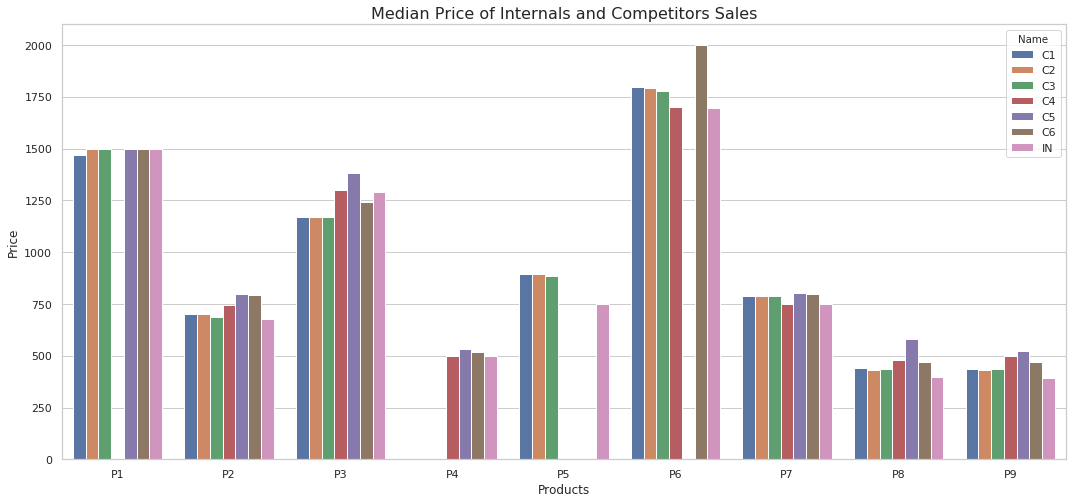

In [100]:
plt.figure(figsize=(18, 8))

sns.barplot(x='Product', y='Price', hue='Name', palette='deep', data=df)

plt.title('Median Price of Internals and Competitors Sales', fontsize=16)
plt.xlabel('Products')

plt.show()

No gráfico acima é possível observar a mediana dos preços de vendas tanto das internas quanto dos concorretntes. Podemos analisar a barra rosa, que está rotulada como "IN (vendas internas)" que praticamente em todos os produtos o preço de venda se encontra abaixo do mercado.

In [101]:
df_competitors = df[df['Type'] == 'Competitor'].reset_index()
df_internals = df[df['Type'] == 'Internal'].reset_index()

In [102]:
df_internals['Percentage'] = df_internals.Frequency.map(lambda x: (x / df_internals.Frequency.sum())*100)
df_summary_internal = df_internals.sort_values('Percentage', ascending=False)[['Product', 'Name', 'Price', 'Frequency', 'Percentage']]

In [103]:
df_summary_internal

,Product,Name,Price,Frequency,Percentage
6,P7,IN,749.00,195939,55.808608
1,P2,IN,678.99,63358,18.046034
7,P8,IN,394.90,27840,7.929568
4,P5,IN,749.00,19775,5.632443
8,P9,IN,393.98,18431,5.249636
3,P4,IN,499.00,14656,4.174416
5,P6,IN,1697.89,4102,1.168358
0,P1,IN,1499.00,4091,1.165225
2,P3,IN,1287.89,2899,0.825712


In [104]:
df_competitors_p1 = df_competitors[df_competitors['Product'] == 'P1'].reset_index()
df_competitors_p2 = df_competitors[df_competitors['Product'] == 'P2'].reset_index()
df_competitors_p3 = df_competitors[df_competitors['Product'] == 'P3'].reset_index()
df_competitors_p4 = df_competitors[df_competitors['Product'] == 'P4'].reset_index()
df_competitors_p5 = df_competitors[df_competitors['Product'] == 'P5'].reset_index()
df_competitors_p6 = df_competitors[df_competitors['Product'] == 'P6'].reset_index()
df_competitors_p7 = df_competitors[df_competitors['Product'] == 'P7'].reset_index()
df_competitors_p8 = df_competitors[df_competitors['Product'] == 'P8'].reset_index()
df_competitors_p9 = df_competitors[df_competitors['Product'] == 'P9'].reset_index()

In [105]:
df_competitors_p1['Percentage'] = (df_competitors_p1.Frequency / df_competitors_p1.Frequency.sum()) * 100
df_summary_p1 = df_competitors_p1.sort_values('Percentage', ascending=False)[['Product', 'Name', 'Price', 'Frequency', 'Percentage']]

In [106]:
df_competitors_p2['Percentage'] = (df_competitors_p2.Frequency / df_competitors_p2.Frequency.sum()) * 100
df_summary_p2 = df_competitors_p2.sort_values('Percentage', ascending=False)[['Product', 'Name', 'Price', 'Frequency', 'Percentage']]

In [107]:
df_competitors_p3['Percentage'] = (df_competitors_p3.Frequency / df_competitors_p3.Frequency.sum()) * 100
df_summary_p3 = df_competitors_p3.sort_values('Percentage', ascending=False)[['Product', 'Name', 'Price', 'Frequency', 'Percentage']]

In [108]:
df_competitors_p4['Percentage'] = (df_competitors_p4.Frequency / df_competitors_p4.Frequency.sum()) * 100
df_summary_p4 = df_competitors_p4.sort_values('Percentage', ascending=False)[['Product', 'Name', 'Price', 'Frequency', 'Percentage']]

In [109]:
df_competitors_p5['Percentage'] = (df_competitors_p5.Frequency / df_competitors_p5.Frequency.sum()) * 100
df_summary_p5 = df_competitors_p5.sort_values('Percentage', ascending=False)[['Product', 'Name', 'Price', 'Frequency', 'Percentage']]

In [110]:
df_competitors_p6['Percentage'] = (df_competitors_p6.Frequency / df_competitors_p6.Frequency.sum()) * 100
df_summary_p6 = df_competitors_p6.sort_values('Percentage', ascending=False)[['Product', 'Name', 'Price', 'Frequency', 'Percentage']]

In [111]:
df_competitors_p7['Percentage'] = (df_competitors_p7.Frequency / df_competitors_p7.Frequency.sum()) * 100
df_summary_p7 = df_competitors_p7.sort_values('Percentage', ascending=False)[['Product', 'Name', 'Price', 'Frequency', 'Percentage']]

In [112]:
df_competitors_p8['Percentage'] = (df_competitors_p8.Frequency / df_competitors_p8.Frequency.sum()) * 100
df_summary_p8 = df_competitors_p8.sort_values('Percentage', ascending=False)[['Product', 'Name', 'Price', 'Frequency', 'Percentage']]

In [113]:
df_competitors_p9['Percentage'] = (df_competitors_p9.Frequency / df_competitors_p9.Frequency.sum()) * 100
df_summary_p9 = df_competitors_p9.sort_values('Percentage', ascending=False)[['Product', 'Name', 'Price', 'Frequency', 'Percentage']]

In [114]:
df_summary = pd.concat([
    df_summary_p1,
    df_summary_p2, 
    df_summary_p3, 
    df_summary_p4,
    df_summary_p5,
    df_summary_p6,
    df_summary_p7, 
    df_summary_p8, 
    df_summary_p9
])

In [115]:
df_summary.head()

,Product,Name,Price,Frequency,Percentage
0,P1,C1,1469.02,765,28.197567
4,P1,C5,1499.00,713,26.280870
1,P1,C2,1499.00,703,25.912274
2,P1,C3,1499.00,396,14.596388
5,P1,C6,1499.00,136,5.012901


In [116]:
freq_comps = df_competitors.groupby('Product')['Frequency'].sum().reset_index()
freq_comps['Percentage'] = (freq_comps.Frequency / freq_comps.Frequency.sum()) * 100

freq_comps['Type'] = 'Competitor'
df_summary_internal['Type'] = 'Internal'

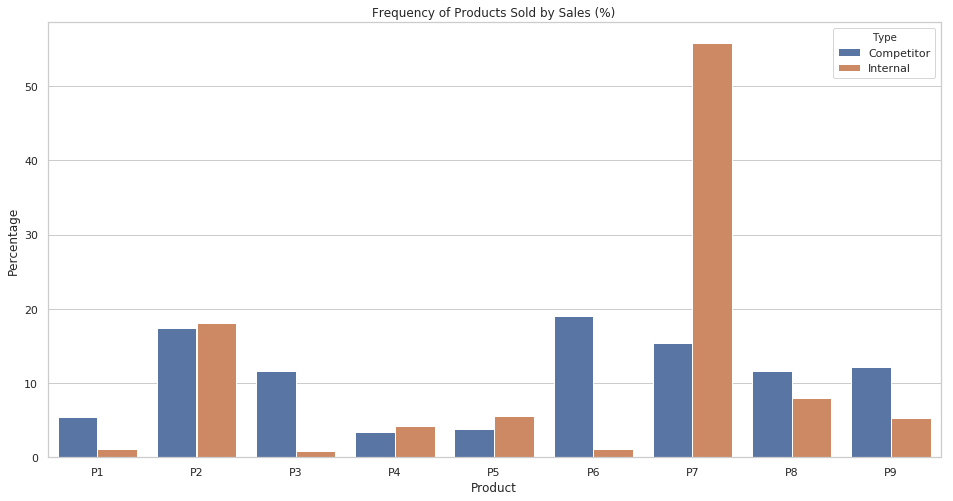

In [117]:
plt.figure(figsize=(16, 8))

sns.barplot(
    x='Product', 
    y='Percentage', 
    hue='Type',
    data=pd.concat([freq_comps, df_summary_internal[['Product', 'Frequency', 'Percentage', 'Type']]]))

plt.title('Frequency of Products Sold by Sales (%)')

plt.show()

No gráfico acima é possível analisar o percentual de frequência de cada produto comprado pr cada cliente. Ao observar o gráfico, vemos que nas vendas internas o produto P7 tem um destaque significativo em cada venda, porém ao analisarmos os outros produtos, vemos que grande parte deles os clientes que compram no concorrente acaba consumindo mais esses produtos.

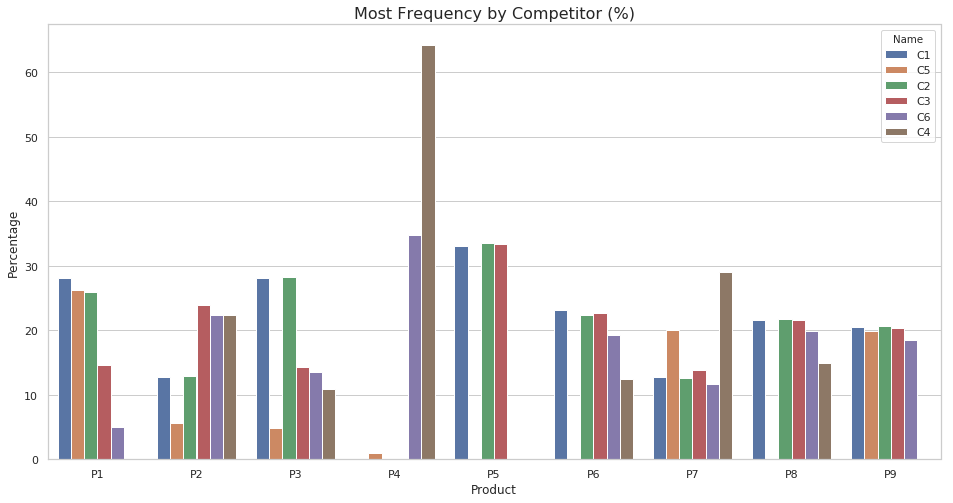

In [118]:
plt.figure(figsize=(16, 8))

sns.barplot(x='Product', y='Percentage', hue='Name', data=df_summary)

plt.title('Most Frequency by Competitor (%)', fontsize=16)

plt.show()

No gráfico acima apresenta o percentual de frequência de cada produto por concorrente.

Total price by product:

  PROD_ID  COMPETITOR_PRICE
0      P6       18622108.13
1      P3        8320806.07
2      P2        7178053.97
3      P7        6922414.27
4      P1        5175114.48
5      P9        3267792.14
6      P8        2952614.91
7      P5        2165781.64
8      P4        1086072.91

Total sold by product:

  PROD_ID      REVENUE
0      P7  161242141.7
1      P2   46017485.2
2      P5   15907636.1
3      P8   12157680.4
4      P4    8456698.4
5      P9    7978901.5
6      P6    7079519.7
7      P1    6014096.7
8      P3    3714170.0



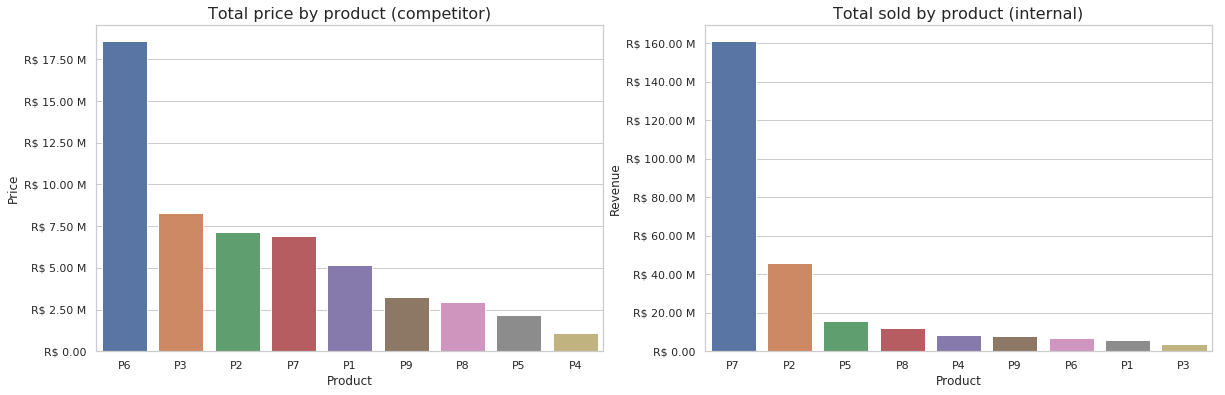

In [58]:
df_comp_sorted = df_comp \
        .groupby('PROD_ID')['COMPETITOR_PRICE'] \
        .sum() \
        .sort_values(ascending=False) \
        .to_frame() \
        .reset_index()

df_sales_sorted = round(df_sales.groupby('PROD_ID')['REVENUE'].sum(), 1).sort_values(ascending=False).to_frame().reset_index()

print('Total price by product:')

print('')
print(df_comp_sorted)
print('')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(x='PROD_ID', y='COMPETITOR_PRICE', data=df_comp_sorted, ax=ax1)

ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))
ax1.set_title('Total price by product (competitor)', fontsize=16)
ax1.set_xlabel('Product')
ax1.set_ylabel('Price')

print('Total sold by product:')

print('')
print(df_sales_sorted)
print('')

sns.barplot(x='PROD_ID', y='REVENUE', data=df_sales_sorted, ax=ax2)

ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))
ax2.set_title('Total sold by product (internal)', fontsize=16)
ax2.set_xlabel('Product')
ax2.set_ylabel('Revenue')

plt.show()

- Os produtos mais vendidos entre todos os competidores estão ordenados por ordem de grandeza no primeiro gráfico.
- Podemos observar que o comportamento das vendas dos concorrentes são diferentes das vendas internas, apesar de termos uma ordem de grandeza no valor totalmente diferente entre eles, o gráfico nos indica que os clientes que compram com os concorrentes, compram determinados produtos com mais frequência, comparado as vendas internas.

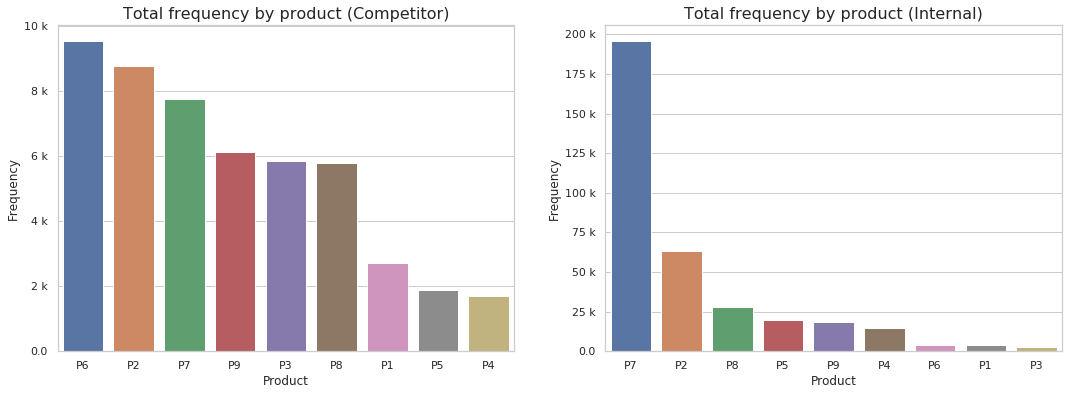

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x='index', y='PROD_ID', data=df_comp.PROD_ID.value_counts().reset_index(), ax=ax1)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))
ax1.set_title('Total frequency by product (Competitor)', fontsize=16)
ax1.set_xlabel('Product')
ax1.set_ylabel('Frequency')

sns.barplot(x='index', y='PROD_ID', data=df_sales.PROD_ID.value_counts().reset_index(), ax=ax2)

ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))
ax2.set_title('Total frequency by product (Internal)', fontsize=16)
ax2.set_xlabel('Product')
ax2.set_ylabel('Frequency')

plt.show()

- Nos gráficos de frequências podemos observar que existem comportamentos totalmente diferentes, porém a ordem de grandeza nas vendas internas são muito maiores do que a dos concorrentes.
- Se levarmos em consideração o comportamento das vendas, vemos que a maioria dos produtos mais vendidos dos competidores são totalmente diferente, como por exemplo o produto 6, que é muito mais vendido do que os outros produtos. Já para as vendas internas ele não possui tanta saída em relação aos outros.

PROD_ID      P1    P2    P3    P4   P5    P6    P7    P8    P9
COMPETITOR                                                    
C1          765  1122  1646     0  628  2210   991  1253  1253
C2          703  1128  1652     0  636  2142   979  1263  1267
C3          396  2089   835     0  632  2166  1077  1253  1247
C4            0  1959   639  1085    0  1190  2249   863     4
C5          713   494   286    16    0     0  1549    14  1215
C6          136  1963   795   588    0  1834   903  1149  1137


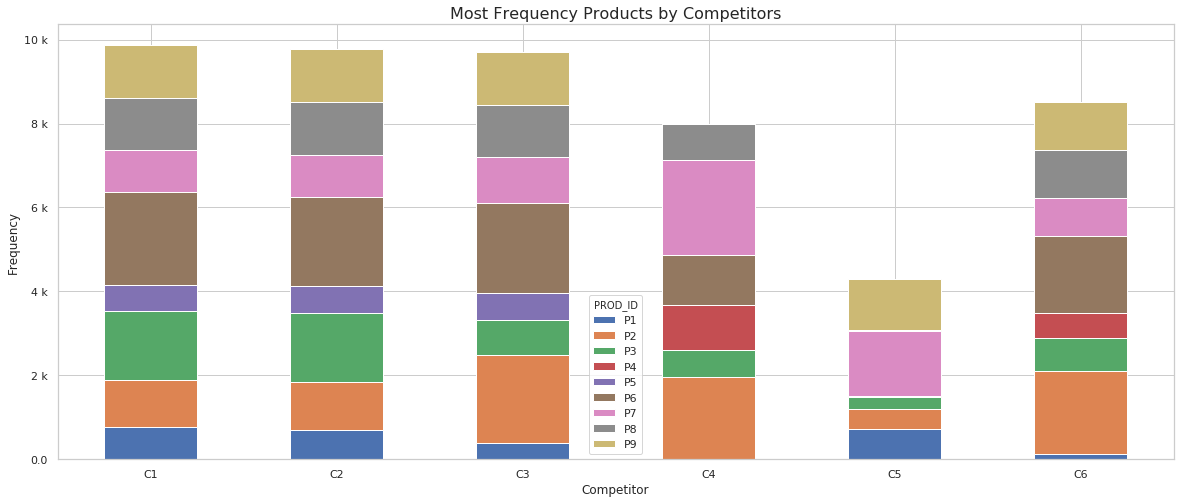

In [60]:
crosstab = pd.crosstab(
    index=df_comp.COMPETITOR,
    columns=df_comp.PROD_ID
)

print(crosstab)

f, ax = plt.subplots(figsize=(20, 8))

crosstab.plot(kind='bar', stacked=True, ax=ax)

plt.title('Most Frequency Products by Competitors', fontsize=16)
plt.xlabel('Competitor')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

ax.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))

plt.show()

- Neste gráfico podemos analisar a frequência de cada produto por concorrente.
- Analisando o gráfico acima, vemos que o produto P6 e P2 são muito vendido, independente do concorrente, exceto o concorrente C5.
- Podemos analisar também que o produto P7 tem uma variação entre os concorrentes, para os C4 e C5 eles tem uma venda boa.

Total price by competitor and product:

  COMP_PROD  COMPETITOR_PRICE
0     C1.P6        4168536.93
1     C2.P6        4085759.53
2     C3.P6        4063698.17
3     C6.P6        3944849.34
4     C4.P6        2359264.16
5     C2.P3        2206311.07
6     C1.P3        2186273.41
7     C4.P7        1850679.47
8     C6.P2        1695639.38
9     C4.P2        1628900.41



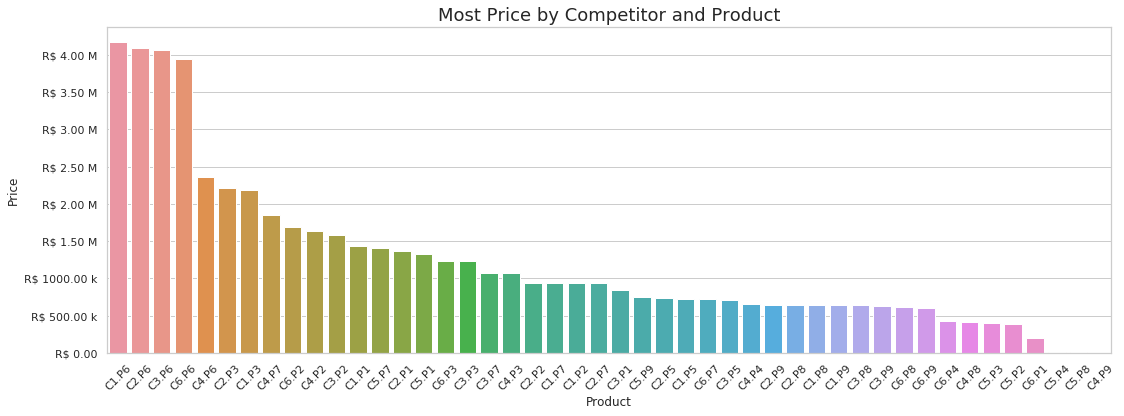

In [62]:
df = df_comp \
        .groupby('COMP_PROD')['COMPETITOR_PRICE'] \
        .sum() \
        .sort_values(ascending=False) \
        .to_frame() \
        .reset_index()

print('Total price by competitor and product:')

print('')
print(df[:10])
print('')

fig, ax = plt.subplots()

fig.set_size_inches((18, 6))

sns.barplot(x='COMP_PROD', y='COMPETITOR_PRICE', data=df)

plt.title('Most Price by Competitor and Product', fontsize=18)
plt.xlabel('Product')
plt.ylabel('Price')

ax.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

plt.xticks(rotation=45)

plt.show()

- Podemos analisar que o produto 6 tem um valor de venda superior aos outros produtos, independente do concorrente, exceto o concorrente 4 que tem um valor muito abaixo em relação aos outros concorrentes.

   PaymentType  Quantity
0            1     25072
1            2     25042



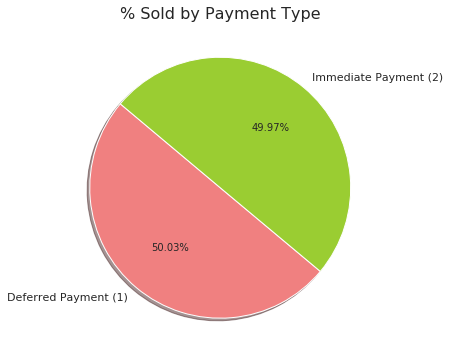

In [63]:
payments = df_comp.groupby('PAY_TYPE')['PROD_ID'].count().reset_index()
payments.columns = ['PaymentType', 'Quantity']

print(payments)
print('')

plt.figure(figsize=(12, 6))

plt.pie(
    payments.Quantity.values, 
    labels=payments.PaymentType.map(set_payment_type), 
    colors=['lightcoral', 'yellowgreen'], 
    shadow=True, 
    startangle=140,
    autopct='%1.2f%%'
)

plt.title('% Sold by Payment Type', fontsize=16)

plt.show()

Max value: R$ 6935362.06


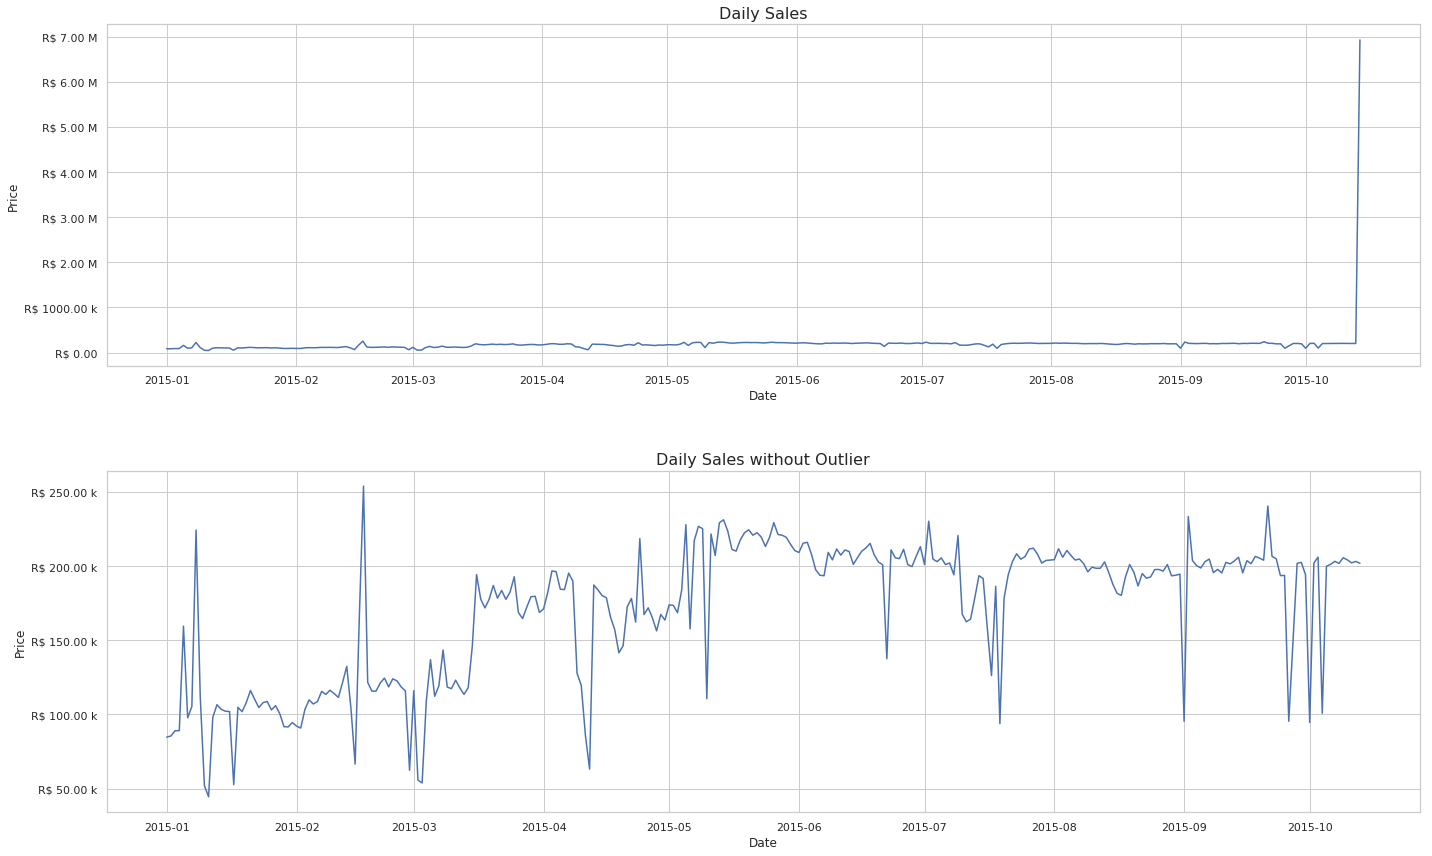

In [64]:
sale_by_date = df_comp.groupby('DATE')['COMPETITOR_PRICE'].sum().reset_index().sort_values(by='DATE')
sale_by_date.columns = ['Date', 'Price']

print('Max value: R$ %.2f' % sale_by_date.max().values[1])

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

sns.lineplot(x='Date', y='Price', data=sale_by_date, ax=ax1)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))
ax1.set_title('Daily Sales', fontsize=16)

sns.lineplot(x='Date', y='Price', data=sale_by_date[sale_by_date['Price'] < 6000000], ax=ax2)
ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))
ax2.set_title('Daily Sales without Outlier', fontsize=16)

plt.tight_layout(h_pad=5)

plt.show()

**Daily Sales**
- Neste gráfico podemos analisar no final do mês de outubro que temos uma venda de aproximadamente 7 milhões. Como este valor é muito grande, acaba tendo mais destaque do as vendas dos outros dias.

**Daily Sales without Outlier**
- Removendo o valor de 7 milhões, podemos analisar o comportamento do preço final das vendas do ano de 2015.
- Ao analisar a linha do gráfico, vemos que há um aumento no valor das vendas conforme o passar dos meses.
- Apesar do aumento no valor das vendas no período, podemos observar diversos picos na diminuição do valor das vendas.

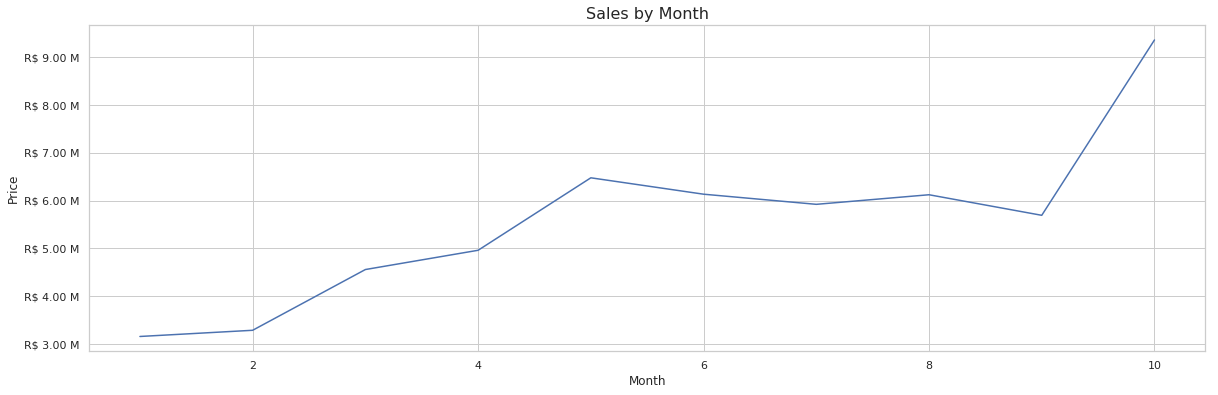

In [65]:
sales_by_month = df_comp.groupby('MONTH')['COMPETITOR_PRICE'].sum().reset_index()
sales_by_month.columns = ['Month', 'Price']

f, ax1 = plt.subplots(1, 1, figsize=(20, 6))

sns.lineplot(x='Month', y='Price', data=sales_by_month, ax=ax1)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))
ax1.set_title('Sales by Month', fontsize=16)

plt.show()

- Como observado no gráfico anterior, podemos concluir um aumento no valor das venda ao longo do período.

## P1

In [67]:
df_comp_p1 = df_comp[df_comp.PROD_ID == 'P1']
df_comp_p1.head(10)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY,COMP_PROD
17290,P1,2015-03-16 20:10:14,C5,1424.05,2,2015-03-16,2015,3,16,0,C5.P1
17291,P1,2015-03-16 20:10:14,C2,1362.50,2,2015-03-16,2015,3,16,0,C2.P1
17292,P1,2015-03-16 20:10:14,C6,1499.00,2,2015-03-16,2015,3,16,0,C6.P1
17310,P1,2015-03-16 08:11:32,C5,1499.00,2,2015-03-16,2015,3,16,0,C5.P1
17311,P1,2015-03-16 08:11:32,C6,1499.00,2,2015-03-16,2015,3,16,0,C6.P1
17312,P1,2015-06-18 20:10:22,C1,1349.10,2,2015-06-18,2015,6,18,3,C1.P1
17313,P1,2015-06-18 20:10:22,C2,1259.10,2,2015-06-18,2015,6,18,3,C2.P1
17314,P1,2015-06-18 20:10:22,C3,1259.10,2,2015-06-18,2015,6,18,3,C3.P1
17315,P1,2015-06-18 20:10:22,C5,1424.05,2,2015-06-18,2015,6,18,3,C5.P1
17316,P1,2015-03-20 08:12:50,C1,1499.00,1,2015-03-20,2015,3,20,4,C1.P1


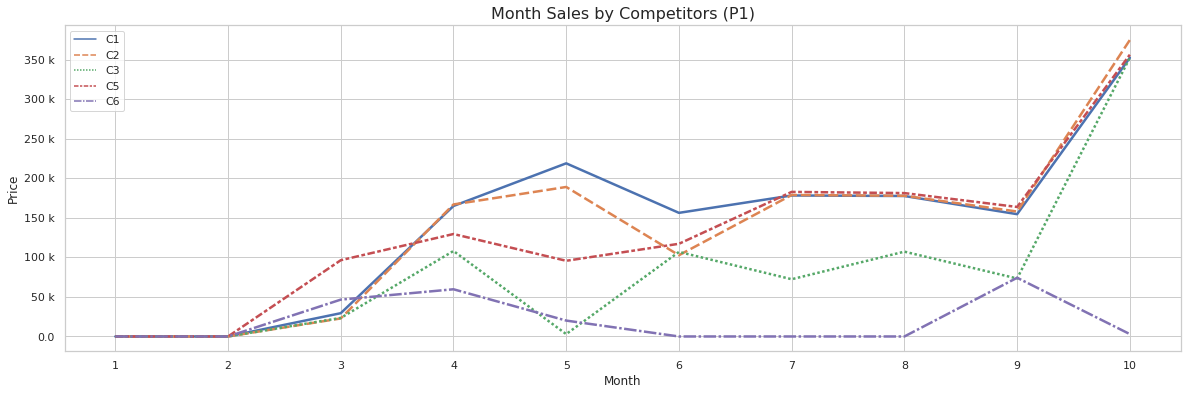

In [68]:
sales_by_comp_month = df_comp_p1.groupby(['MONTH', 'COMPETITOR'])['COMPETITOR_PRICE'].sum().reset_index()
sales_by_comp_month.columns = ['Month', 'Competitor', 'Price']

competitors = sales_by_comp_month.Competitor.sort_values().unique()
months = np.arange(10) + 1

total_competitors = sales_by_comp_month.Competitor.nunique()

values = []

for x in months:
    item = []
    
    for j in np.arange(total_competitors):
        price = sales_by_comp_month[(sales_by_comp_month['Month'] == x) & (sales_by_comp_month['Competitor'] == competitors[j])]['Price'].values
        
        item.append(round(price[0], 2) if len(price) > 0 else 0)

    values.append(item)

data = pd.DataFrame(
    data = values, 
    index = months,
    columns=competitors
)

f, ax1 = plt.subplots(1, 1, figsize=(20, 6))

sns.lineplot(data=data, linewidth=2.5, ax=ax1)

ax1.set_title('Month Sales by Competitors (P1)', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Price')

ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))

ax1.set_xticks(months)

plt.show()

- No gráfico acima podemos comparar o valor total das vendas entre os concorrentes no exercício de 2015.
- Os concorrentes C1, C2, C3 e C5 vem tendo um aumento nas vendas ao longo do tempo.
- O concorrente C6 vem tendo um pequeno aumento nas vendas entre fevereiro e março, a partir do mês de abril as suas vendas vem decrescendo e se mantém constante até o mês de agosto, onde tem um pico (crescente) significativo.

       Price           Payment Type  Frequency
12  149900.0  Immediate Payment (2)          1
42  149900.0   Deferred Payment (1)          4
1   134910.0  Immediate Payment (2)          1
17  131912.0  Immediate Payment (2)          2
85    1899.0   Deferred Payment (1)        142
86    1899.0  Immediate Payment (2)        142
19    1829.9   Deferred Payment (1)          2
18    1829.9  Immediate Payment (2)          2
74    1599.9   Deferred Payment (1)         20
73    1599.9  Immediate Payment (2)         20

Payment Type
Deferred Payment (1)     46.153846
Immediate Payment (2)    53.846154
dtype: float64


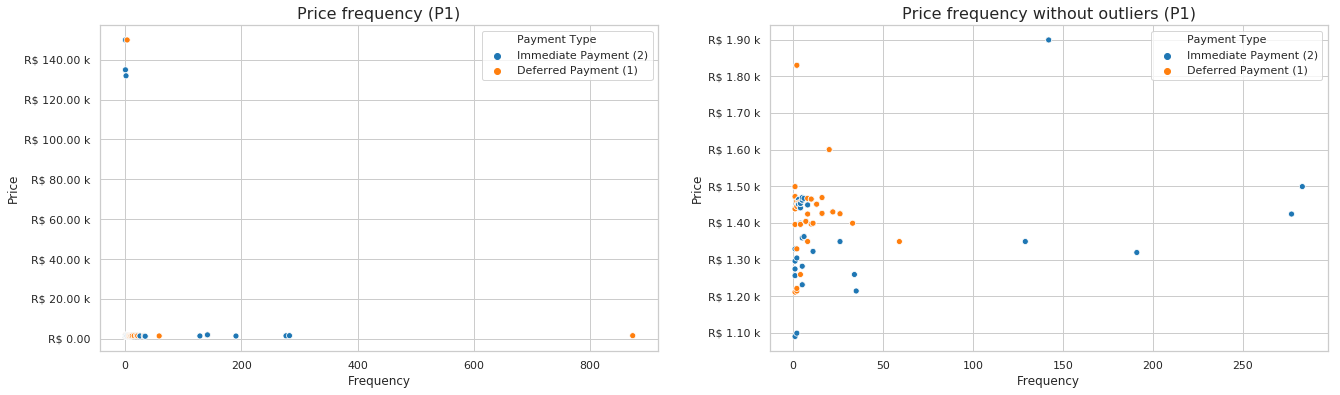

In [70]:
qt_price = df_comp[df_comp['PROD_ID'] == 'P1'].groupby(['COMPETITOR_PRICE', 'PAY_TYPE'])['PROD_ID'].count().sort_values().reset_index()
qt_price.columns = ['Price', 'Payment Type', 'Frequency']
qt_price['Payment Type'] = qt_price['Payment Type'].apply(set_payment_type)

print(qt_price.sort_values(ascending=False, by='Price')[:10])
print('')
print((qt_price.groupby('Payment Type').size() / qt_price.shape[0]) * 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

sns.scatterplot(
    x='Frequency', 
    y='Price',
    hue='Payment Type',
    palette='tab10',
    data=qt_price, 
    ax=ax1
)
ax1.set_title('Price frequency (P1)', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

sns.scatterplot(
    x='Frequency', 
    y='Price', 
    hue='Payment Type',
    palette='tab10',
    data=qt_price[(qt_price['Price'] < 130000) & (qt_price['Frequency'] < 400)], 
    ax=ax2
)
ax2.set_title('Price frequency without outliers (P1)', fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

plt.show()

- No primeiro gráfico, podemos observar 3 valores fora do padrão do restante das vendas, ao remover esses valores vemos que a maioria dos clientes compram mais de uma quantidade. Pois a aglomeração dos pontos encontram-se acima do valor mínimo.
- 54% das vendas foram pago à vista e 46% foram parceladas.

## P2

In [71]:
df_comp_p2 = df_comp[df_comp.PROD_ID == 'P2']
df_comp_p2.head(10)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY,COMP_PROD
17293,P2,2015-02-23 20:10:06,C3,799.00,1,2015-02-23,2015,2,23,0,C3.P2
17294,P2,2015-02-23 20:10:06,C5,829.00,1,2015-02-23,2015,2,23,0,C5.P2
17295,P2,2015-02-23 20:10:06,C4,829.00,1,2015-02-23,2015,2,23,0,C4.P2
17296,P2,2015-02-23 20:10:06,C6,878.00,1,2015-02-23,2015,2,23,0,C6.P2
17297,P2,2015-02-17 08:10:23,C3,778.00,1,2015-02-17,2015,2,17,1,C3.P2
17298,P2,2015-02-17 08:10:23,C5,829.00,1,2015-02-17,2015,2,17,1,C5.P2
17299,P2,2015-02-17 08:10:23,C4,812.42,1,2015-02-17,2015,2,17,1,C4.P2
17300,P2,2015-02-17 08:10:23,C6,879.00,1,2015-02-17,2015,2,17,1,C6.P2
17301,P2,2015-02-17 08:11:34,C1,788.00,1,2015-02-17,2015,2,17,1,C1.P2
17302,P2,2015-02-17 08:11:34,C4,829.00,1,2015-02-17,2015,2,17,1,C4.P2


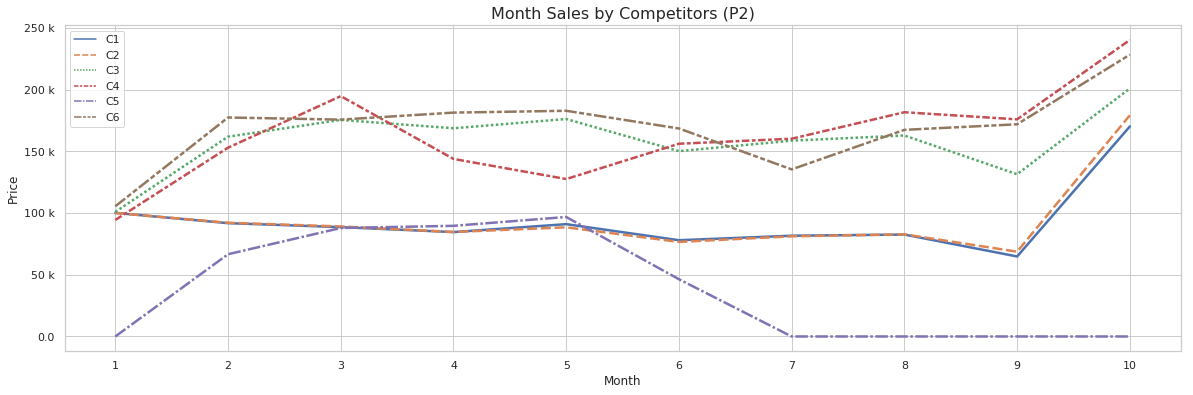

In [72]:
sales_by_comp_month = df_comp_p2.groupby(['MONTH', 'COMPETITOR'])['COMPETITOR_PRICE'].sum().reset_index()
sales_by_comp_month.columns = ['Month', 'Competitor', 'Price']

competitors = sales_by_comp_month.Competitor.sort_values().unique()
months = np.arange(10) + 1

total_competitors = sales_by_comp_month.Competitor.nunique()

values = []

for x in months:
    item = []
    
    for j in np.arange(total_competitors):
        price = sales_by_comp_month[(sales_by_comp_month['Month'] == x) & (sales_by_comp_month['Competitor'] == competitors[j])]['Price'].values
        
        item.append(round(price[0], 2) if len(price) > 0 else 0)

    values.append(item)

data = pd.DataFrame(
    data = values, 
    index = months,
    columns=competitors
)

f, ax1 = plt.subplots(1, 1, figsize=(20, 6))

sns.lineplot(data=data, linewidth=2.5, ax=ax1)

ax1.set_title('Month Sales by Competitors (P2)', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Price')

ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))

ax1.set_xticks(months)

plt.show()

- O concorrente C1 tem um leve aumento no início do ano e tem pequenas variações até o mês abril, a partir do mês de maio as suas vendas vêm diminuindo levemente até ter um aumento em setembro.
- Os concorrentes C2 e C3 tem algumas variações nas vendas duranto o exercício mas no segundo semestre as suas vendas aumentam consideravelmente.
- Os concorrentes C4 e C5 tem as suas vendas constante ao longo do tempo e a partir de setembro as suas vendas aumentam.
- As vendas do concorrente C6 fica em torno de 55 mil no primeiro semestre e ao final vêm decrescendo até não terem mais vendas a partir de julho.

       Price           Payment Type  Frequency
143  79900.0  Immediate Payment (2)          1
24   79900.0   Deferred Payment (1)          1
91   74800.0  Immediate Payment (2)          1
92   74800.0   Deferred Payment (1)          1
93   72498.0  Immediate Payment (2)          1
291  72498.0   Deferred Payment (1)          3
265  65248.0  Immediate Payment (2)          2
541   1089.0   Deferred Payment (1)         13
542   1089.0  Immediate Payment (2)         13
262    979.0   Deferred Payment (1)          2

Payment Type
Deferred Payment (1)     46.944858
Immediate Payment (2)    53.055142
dtype: float64


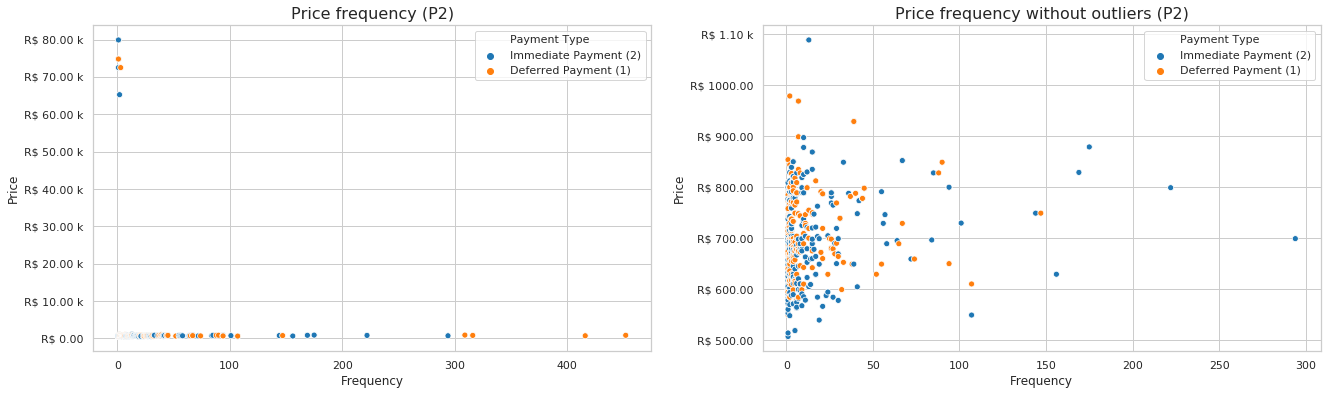

In [73]:
qt_price = df_comp[df_comp['PROD_ID'] == 'P2'].groupby(['COMPETITOR_PRICE', 'PAY_TYPE'])['PROD_ID'].count().sort_values().reset_index()
qt_price.columns = ['Price', 'Payment Type', 'Frequency']
qt_price['Payment Type'] = qt_price['Payment Type'].apply(set_payment_type)

print(qt_price.sort_values(ascending=False, by='Price')[:10])
print('')
print((qt_price.groupby('Payment Type').size() / qt_price.shape[0]) * 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

sns.scatterplot(
    x='Frequency', 
    y='Price',
    hue='Payment Type',
    palette='tab10',
    data=qt_price, 
    ax=ax1
)
ax1.set_title('Price frequency (P2)', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

sns.scatterplot(
    x='Frequency', 
    y='Price', 
    hue='Payment Type',
    palette='tab10',
    data=qt_price[(qt_price['Price'] < 60000) & (qt_price['Frequency'] < 300)], 
    ax=ax2
)
ax2.set_title('Price frequency without outliers (P2)', fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

plt.show()

- A distribuição das vendas por tipo de pagamento estão bem equilibradas, 53% para pagamentos à vista e 47 para pagamento parcelado.
- Podemos observar também que existem alguns valores que estão na faixa de 65 mil à 80 mil. Provavelmente esses produtos devem ter sido vendidos em grande quantidade, pois o agrupamento dos seus pontos ficam em torno de 500 à 1100.

## P3

In [74]:
df_comp_p3 = df_comp[df_comp.PROD_ID == 'P3']
df_comp_p3.head(10)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY,COMP_PROD
37131,P3,2015-03-16 20:10:05,C3,1499.00,1,2015-03-16,2015,3,16,0,C3.P3
37132,P3,2015-03-16 20:10:05,C5,1543.90,1,2015-03-16,2015,3,16,0,C5.P3
37133,P3,2015-03-16 20:10:05,C3,1499.00,2,2015-03-16,2015,3,16,0,C3.P3
37134,P3,2015-03-16 20:10:05,C5,1312.32,2,2015-03-16,2015,3,16,0,C5.P3
37135,P3,2015-03-16 20:10:05,C2,1499.00,2,2015-03-16,2015,3,16,0,C2.P3
37136,P3,2015-03-16 20:10:05,C1,1499.00,2,2015-03-16,2015,3,16,0,C1.P3
37137,P3,2015-03-16 20:10:05,C2,1499.00,1,2015-03-16,2015,3,16,0,C2.P3
37138,P3,2015-03-16 20:10:05,C1,1499.00,1,2015-03-16,2015,3,16,0,C1.P3
37139,P3,2015-03-16 20:10:14,C4,1499.00,2,2015-03-16,2015,3,16,0,C4.P3
37140,P3,2015-03-16 20:10:14,C1,1498.99,2,2015-03-16,2015,3,16,0,C1.P3


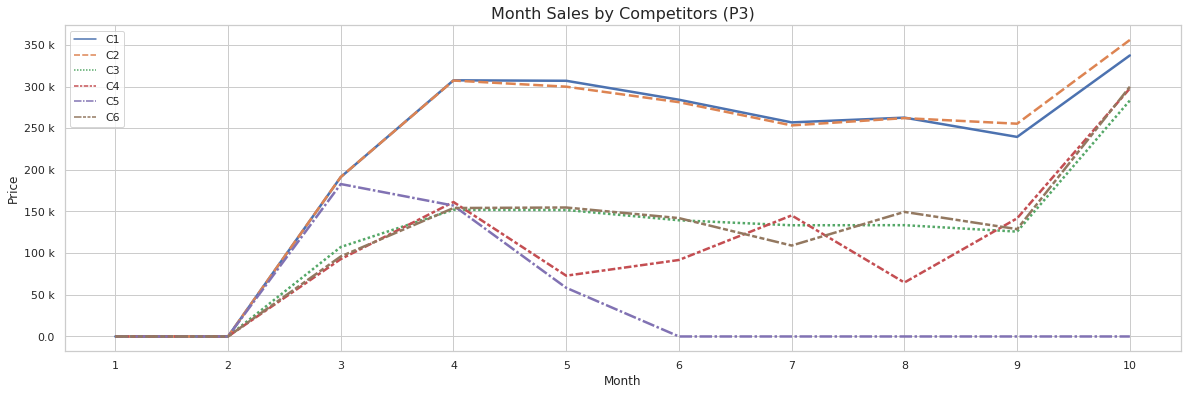

In [75]:
sales_by_comp_month = df_comp_p3.groupby(['MONTH', 'COMPETITOR'])['COMPETITOR_PRICE'].sum().reset_index()
sales_by_comp_month.columns = ['Month', 'Competitor', 'Price']

competitors = sales_by_comp_month.Competitor.sort_values().unique()
months = np.arange(10) + 1

total_competitors = sales_by_comp_month.Competitor.nunique()

values = []

for x in months:
    item = []
    
    for j in np.arange(total_competitors):
        price = sales_by_comp_month[(sales_by_comp_month['Month'] == x) & (sales_by_comp_month['Competitor'] == competitors[j])]['Price'].values
        
        item.append(round(price[0], 2) if len(price) > 0 else 0)

    values.append(item)

data = pd.DataFrame(
    data = values, 
    index = months,
    columns=competitors
)

f, ax1 = plt.subplots(1, 1, figsize=(20, 6))

sns.lineplot(data=data, linewidth=2.5, ax=ax1)
ax1.set_title('Month Sales by Competitors (P3)', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Price')

ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))

ax1.set_xticks(months)

plt.show()

- Os concorrentes C1 e C2 possuem praticamente o mesmo comportamento, tendo um crescimento a partir de fevereiro até março, em abril eles tem uma leve queda nas vendas e em setembro voltam novamente a crescer o valor de suas vendas.
- Os concorrentes C3 C4 e C6 também possuem um comportamento pareeido, exceto o concorrente C4 que em alguns meses tem uma diminuição nas vendas.
- O concorrente C5 tem um crescimento no mês de fevereiro e de março até maio vem decrescendo, a partir de junho suas vendas ficam constante.

         Price           Payment Type  Frequency
246  119900.00   Deferred Payment (1)          5
186  119900.00  Immediate Payment (2)          3
97   107910.00  Immediate Payment (2)          1
101  105512.00  Immediate Payment (2)          1
422    1543.90   Deferred Payment (1)         43
301    1502.91   Deferred Payment (1)          8
446    1499.00   Deferred Payment (1)        305
443    1499.00  Immediate Payment (2)        198
424    1498.99   Deferred Payment (1)         46
425    1498.99  Immediate Payment (2)         46

Payment Type
Deferred Payment (1)     46.756152
Immediate Payment (2)    53.243848
dtype: float64


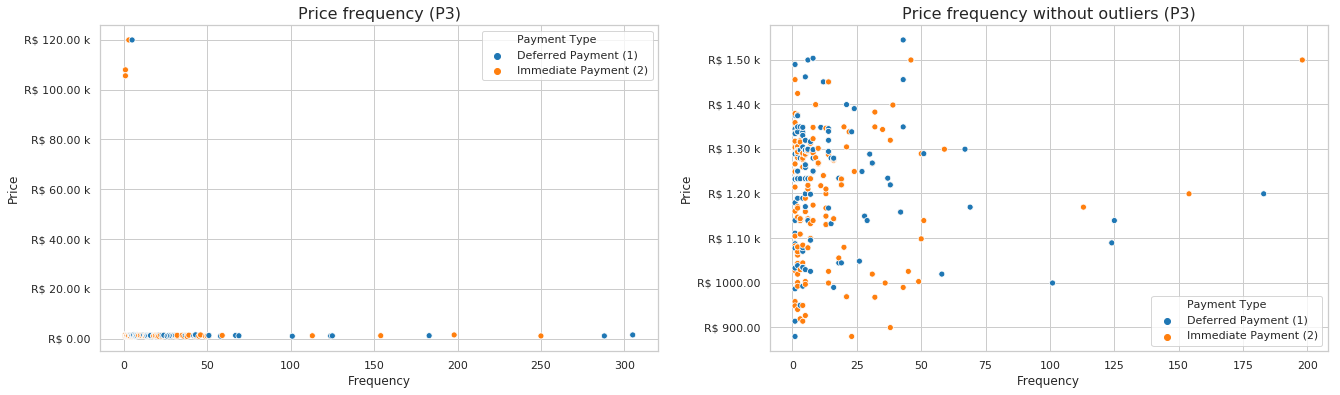

In [76]:
qt_price = df_comp[df_comp['PROD_ID'] == 'P3'].groupby(['COMPETITOR_PRICE', 'PAY_TYPE'])['PROD_ID'].count().sort_values().reset_index()
qt_price.columns = ['Price', 'Payment Type', 'Frequency']
qt_price['Payment Type'] = qt_price['Payment Type'].apply(set_payment_type)

print(qt_price.sort_values(ascending=False, by='Price')[:10])
print('')
print((qt_price.groupby('Payment Type').size() / qt_price.shape[0]) * 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

sns.scatterplot(
    x='Frequency', 
    y='Price',
    hue='Payment Type',
    palette='tab10',
    data=qt_price, 
    ax=ax1
)
ax1.set_title('Price frequency (P3)', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

sns.scatterplot(
    x='Frequency', 
    y='Price', 
    hue='Payment Type',
    palette='tab10',
    data=qt_price[(qt_price['Price'] < 100000) & (qt_price['Frequency'] < 200)], 
    ax=ax2
)
ax2.set_title('Price frequency without outliers (P3)', fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

plt.show()

- A distribuição dos preços das vendas estão bem equalizadas, assim como os outros produtos. Seus percentuais estão em 53% para compras para pagamento à vista e 47% para compras parceladas.
- Podemos analisar alguns outliers no primeiro gráfico, que estão em torno de 110 mil à 122 mil. Ao remover-mos eles, olhamos para o segundo gráfico e temos uma melhor visualização dos dados, onde nos mostra um agrupamento forte de pontos entre 1 e 50, que significa que grande parte dos clientes estão gastando entre 850 à 1500 por compra.

## P4

In [78]:
df_comp_p4 = df_comp[df_comp.PROD_ID == 'P4']
df_comp_p4.head(10)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY,COMP_PROD
44898,P4,2015-06-18 08:11:39,C6,499.0,1,2015-06-18,2015,6,18,3,C6.P4
44899,P4,2015-06-18 08:11:39,C4,569.0,1,2015-06-18,2015,6,18,3,C4.P4
44900,P4,2015-06-16 20:10:25,C4,569.0,2,2015-06-16,2015,6,16,1,C4.P4
44901,P4,2015-06-16 20:10:25,C6,499.0,2,2015-06-16,2015,6,16,1,C6.P4
44902,P4,2015-06-16 20:10:08,C4,569.0,1,2015-06-16,2015,6,16,1,C4.P4
44903,P4,2015-08-11 08:10:22,C4,569.0,2,2015-08-11,2015,8,11,1,C4.P4
44904,P4,2015-08-11 08:11:24,C4,569.0,1,2015-08-11,2015,8,11,1,C4.P4
44905,P4,2015-08-11 08:11:24,C6,548.0,1,2015-08-11,2015,8,11,1,C6.P4
44906,P4,2015-08-11 08:10:22,C4,569.0,1,2015-08-11,2015,8,11,1,C4.P4
44907,P4,2015-08-14 08:11:26,C4,499.9,2,2015-08-14,2015,8,14,4,C4.P4


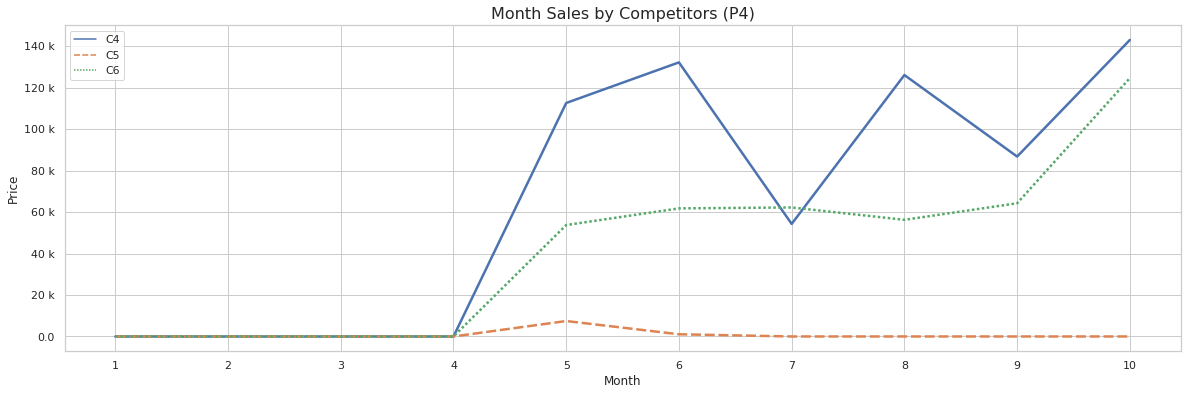

In [79]:
sales_by_comp_month = df_comp_p4.groupby(['MONTH', 'COMPETITOR'])['COMPETITOR_PRICE'].sum().reset_index()
sales_by_comp_month.columns = ['Month', 'Competitor', 'Price']

competitors = sales_by_comp_month.Competitor.sort_values().unique()
months = np.arange(10) + 1

total_competitors = sales_by_comp_month.Competitor.nunique()

values = []

for x in months:
    item = []
    
    for j in np.arange(total_competitors):
        price = sales_by_comp_month[(sales_by_comp_month['Month'] == x) & (sales_by_comp_month['Competitor'] == competitors[j])]['Price'].values
        
        item.append(round(price[0], 2) if len(price) > 0 else 0)

    values.append(item)

data = pd.DataFrame(
    data = values, 
    index = months,
    columns=competitors
)

f, ax1 = plt.subplots(1, 1, figsize=(20, 6))

sns.lineplot(data=data, linewidth=2.5, ax=ax1)
ax1.set_title('Month Sales by Competitors (P4)', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Price')

ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))

ax1.set_xticks(months)

plt.show()

- No gráfico acima podemos ver todas as vendas começarem a partir do mês abril e uma curva com grandes variações para o concorrente C4.
- O concorrente C6 tem um crescimento no início do mês de abirl e a partir de maio até agosto possue pequenas variações. Ao chegar em setembro as suas vendas aumentam novamente.
- O concorrente C5 possue um pequeno aumento em suas vendas na metade do mês de abril até início de maio e após isso tem uma queda em suas vendas e ficam constantes ao longo do tempo.

      Price           Payment Type  Frequency
0   49700.0  Immediate Payment (2)          1
9   49700.0   Deferred Payment (1)          1
2   46990.0   Deferred Payment (1)          1
1   46990.0  Immediate Payment (2)          1
51    655.0   Deferred Payment (1)         33
50    655.0  Immediate Payment (2)         33
62    629.9   Deferred Payment (1)         69
61    629.9  Immediate Payment (2)         69
65    569.0  Immediate Payment (2)        189
66    569.0   Deferred Payment (1)        201

Payment Type
Deferred Payment (1)     47.761194
Immediate Payment (2)    52.238806
dtype: float64


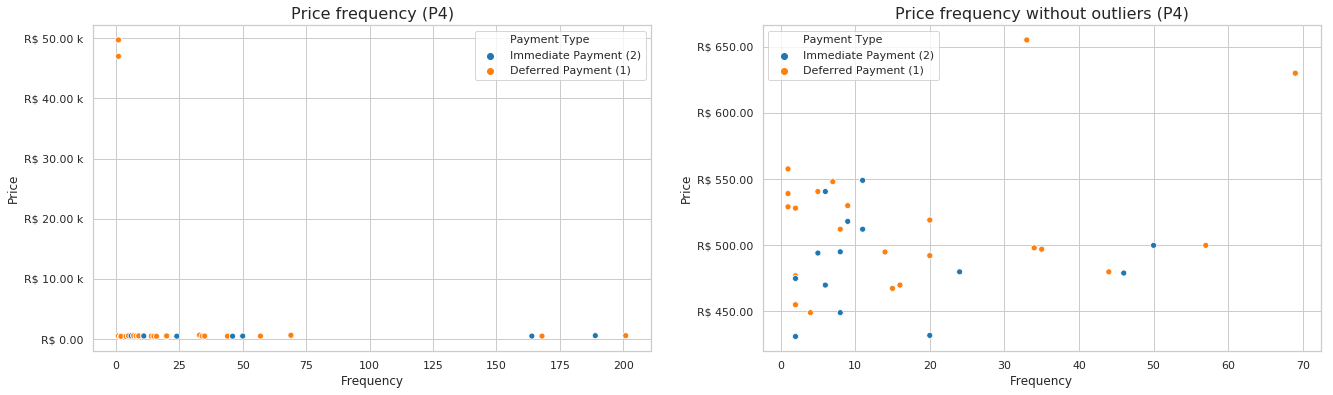

In [80]:
qt_price = df_comp[df_comp['PROD_ID'] == 'P4'].groupby(['COMPETITOR_PRICE', 'PAY_TYPE'])['PROD_ID'].count().sort_values().reset_index()
qt_price.columns = ['Price', 'Payment Type', 'Frequency']
qt_price['Payment Type'] = qt_price['Payment Type'].apply(set_payment_type)

print(qt_price.sort_values(ascending=False, by='Price')[:10])
print('')
print((qt_price.groupby('Payment Type').size() / qt_price.shape[0]) * 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

sns.scatterplot(
    x='Frequency', 
    y='Price',
    hue='Payment Type',
    palette='tab10',
    data=qt_price, 
    ax=ax1
)
ax1.set_title('Price frequency (P4)', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

sns.scatterplot(
    x='Frequency', 
    y='Price', 
    hue='Payment Type',
    palette='tab10',
    data=qt_price[(qt_price['Price'] < 40000) & (qt_price['Frequency'] < 150)], 
    ax=ax2
)
ax2.set_title('Price frequency without outliers (P4)', fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

plt.show()

- Assim como nos outros gráficos, podemos observar 4 valores distante da média de preço.
- Podemos analisar no segundo gráfico que grande parte das frequências dos preços estão entre 1 e 20.

## P5

In [81]:
df_comp_p5 = df_comp[df_comp.PROD_ID == 'P5']
df_comp_p5.head(10)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY,COMP_PROD
48169,P5,2015-06-18 20:10:22,C3,894.98,1,2015-06-18,2015,6,18,3,C3.P5
48170,P5,2015-06-18 20:10:22,C1,894.98,1,2015-06-18,2015,6,18,3,C1.P5
48171,P5,2015-06-18 20:10:22,C2,894.97,1,2015-06-18,2015,6,18,3,C2.P5
48172,P5,2015-08-11 08:11:24,C1,838.00,1,2015-08-11,2015,8,11,1,C1.P5
48173,P5,2015-06-16 20:10:25,C1,923.00,2,2015-06-16,2015,6,16,1,C1.P5
48174,P5,2015-06-16 20:10:25,C3,923.00,2,2015-06-16,2015,6,16,1,C3.P5
48175,P5,2015-06-16 20:10:25,C2,923.00,2,2015-06-16,2015,6,16,1,C2.P5
48176,P5,2015-08-11 08:11:24,C2,838.00,1,2015-08-11,2015,8,11,1,C2.P5
48177,P5,2015-08-11 08:11:24,C3,838.00,1,2015-08-11,2015,8,11,1,C3.P5
48184,P5,2015-08-11 08:11:24,C3,838.00,2,2015-08-11,2015,8,11,1,C3.P5


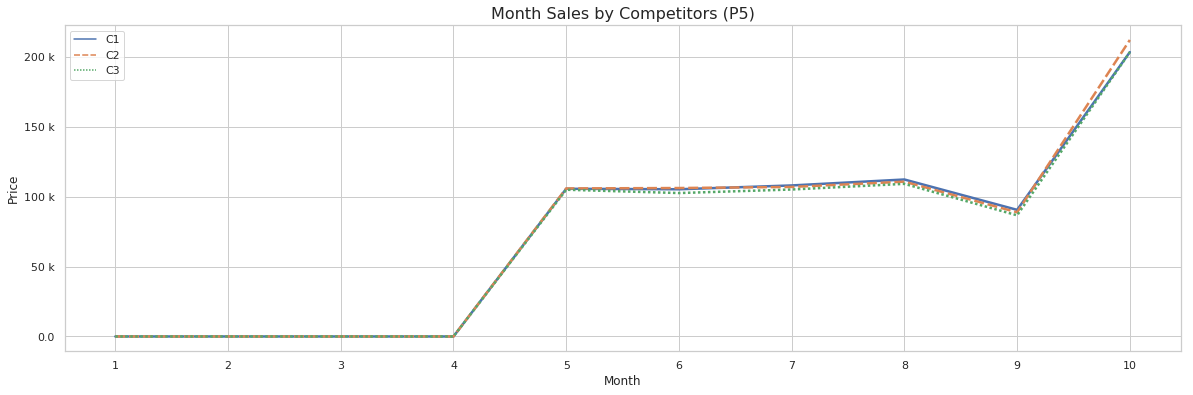

In [82]:
sales_by_comp_month = df_comp_p5.groupby(['MONTH', 'COMPETITOR'])['COMPETITOR_PRICE'].sum().reset_index()
sales_by_comp_month.columns = ['Month', 'Competitor', 'Price']

competitors = sales_by_comp_month.Competitor.sort_values().unique()
months = np.arange(10) + 1

total_competitors = sales_by_comp_month.Competitor.nunique()

values = []

for x in months:
    item = []
    
    for j in np.arange(total_competitors):
        price = sales_by_comp_month[(sales_by_comp_month['Month'] == x) & (sales_by_comp_month['Competitor'] == competitors[j])]['Price'].values
        
        item.append(round(price[0], 2) if len(price) > 0 else 0)

    values.append(item)

data = pd.DataFrame(
    data = values, 
    index = months,
    columns=competitors
)

f, ax1 = plt.subplots(1, 1, figsize=(20, 6))

sns.lineplot(data=data, linewidth=2.5, ax=ax1)
ax1.set_title('Month Sales by Competitors (P5)', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Price')

ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))

ax1.set_xticks(months)

plt.show()

- Ao contrário dos outros gráficos, este tem um comportamento totalmente diferente, todos os concorrentes tem vendas similares ao longo do tempo.

        Price           Payment Type  Frequency
0    84890.00  Immediate Payment (2)          1
12   84890.00   Deferred Payment (1)          1
115  81900.00  Immediate Payment (2)          2
119  81900.00   Deferred Payment (1)          2
57    1299.00   Deferred Payment (1)          1
47    1169.10  Immediate Payment (2)          1
238   1149.00  Immediate Payment (2)         10
237   1149.00   Deferred Payment (1)         10
65    1139.05   Deferred Payment (1)          1
197   1099.00   Deferred Payment (1)          5

Payment Type
Deferred Payment (1)     48.62069
Immediate Payment (2)    51.37931
dtype: float64


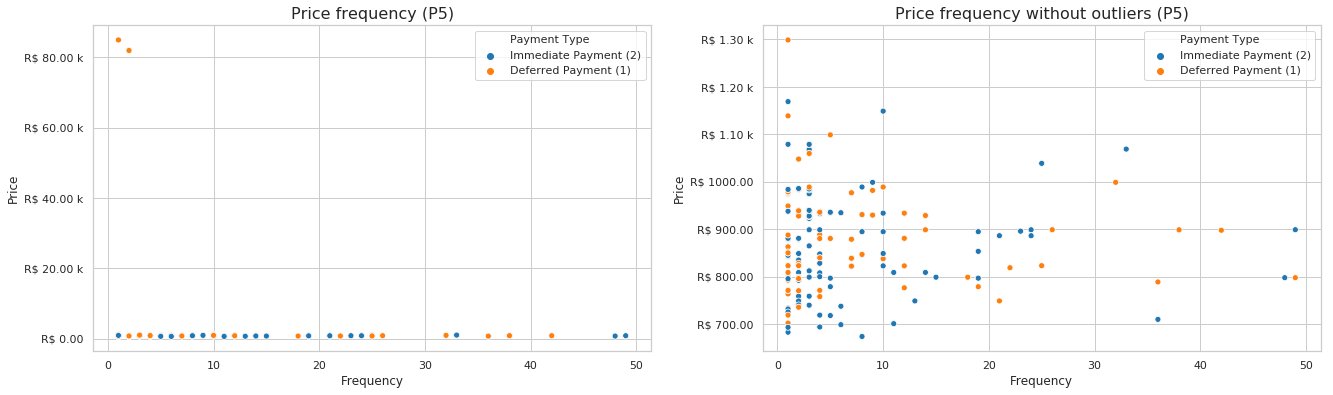

In [83]:
qt_price = df_comp[df_comp['PROD_ID'] == 'P5'].groupby(['COMPETITOR_PRICE', 'PAY_TYPE'])['PROD_ID'].count().sort_values().reset_index()
qt_price.columns = ['Price', 'Payment Type', 'Frequency']
qt_price['Payment Type'] = qt_price['Payment Type'].apply(set_payment_type)

print(qt_price.sort_values(ascending=False, by='Price')[:10])
print('')
print((qt_price.groupby('Payment Type').size() / qt_price.shape[0]) * 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

sns.scatterplot(
    x='Frequency', 
    y='Price',
    hue='Payment Type',
    palette='tab10',
    data=qt_price, 
    ax=ax1
)
ax1.set_title('Price frequency (P5)', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

sns.scatterplot(
    x='Frequency', 
    y='Price', 
    hue='Payment Type',
    palette='tab10',
    data=qt_price[qt_price['Price'] < 40000], 
    ax=ax2
)
ax2.set_title('Price frequency without outliers (P5)', fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

plt.show()

- 51% dos dados são de pagamentos à vista e 49% para compras pareladas, podemos observar também o mesmo comportamento que os outros produtos e concorrentes, onde temos 4 valores distantes da média de preço.
- A frequência dos dados estão entre 1 e 26, que significa que grande parte dos valores das vendas para este produto estão entre 650 e 1200.

## P6

In [84]:
df_comp_p6 = df_comp[df_comp.PROD_ID == 'P6']
df_comp_p6.head(10)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY,COMP_PROD
0,P6,2015-01-30 08:11:38,C3,1898.00,1,2015-01-30,2015,1,30,4,C3.P6
1,P6,2015-01-30 08:11:38,C1,1898.00,1,2015-01-30,2015,1,30,4,C1.P6
2,P6,2015-01-30 08:11:38,C6,1999.90,1,2015-01-30,2015,1,30,4,C6.P6
3,P6,2015-01-31 20:10:14,C2,1894.88,2,2015-01-31,2015,1,31,5,C2.P6
4,P6,2015-01-31 20:10:14,C3,1894.88,2,2015-01-31,2015,1,31,5,C3.P6
5,P6,2015-01-31 20:10:14,C1,1894.88,2,2015-01-31,2015,1,31,5,C1.P6
6,P6,2015-01-31 20:10:14,C6,1999.90,2,2015-01-31,2015,1,31,5,C6.P6
7,P6,2015-01-31 20:10:05,C1,1896.62,1,2015-01-31,2015,1,31,5,C1.P6
8,P6,2015-01-31 20:10:05,C2,2199.00,1,2015-01-31,2015,1,31,5,C2.P6
9,P6,2015-01-31 20:10:05,C3,1895.98,1,2015-01-31,2015,1,31,5,C3.P6


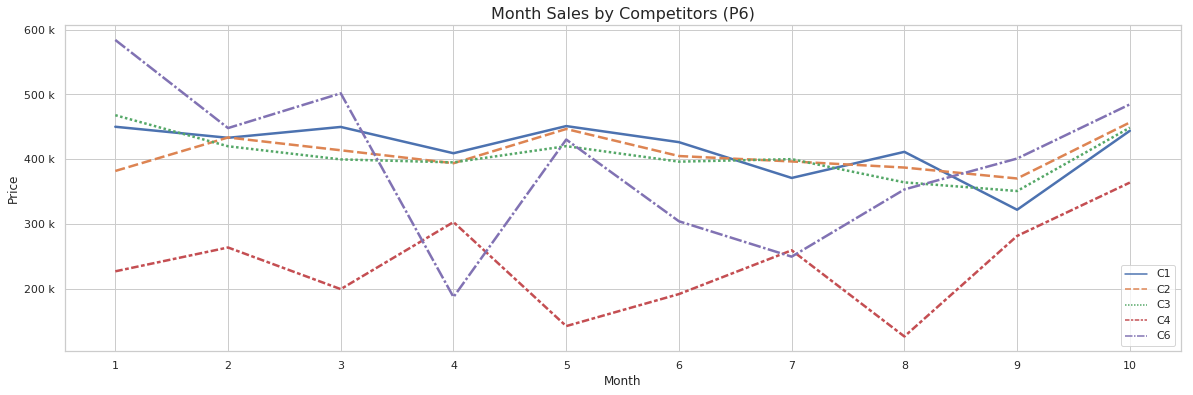

In [85]:
sales_by_comp_month = df_comp_p6.groupby(['MONTH', 'COMPETITOR'])['COMPETITOR_PRICE'].sum().reset_index()
sales_by_comp_month.columns = ['Month', 'Competitor', 'Price']

competitors = sales_by_comp_month.Competitor.sort_values().unique()
months = np.arange(10) + 1

total_competitors = sales_by_comp_month.Competitor.nunique()

values = []

for x in months:
    item = []
    
    for j in np.arange(total_competitors):
        price = sales_by_comp_month[(sales_by_comp_month['Month'] == x) & (sales_by_comp_month['Competitor'] == competitors[j])]['Price'].values
        
        item.append(round(price[0], 2) if len(price) > 0 else 0)

    values.append(item)

data = pd.DataFrame(
    data = values, 
    index = months,
    columns=competitors
)

f, ax1 = plt.subplots(1, 1, figsize=(20, 6))

sns.lineplot(data=data, linewidth=2.5, ax=ax1)
ax1.set_title('Month Sales by Competitors (P6)', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Price')

ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))

ax1.set_xticks(months)

plt.show()

- Os concorrentes C4 e C6 possuem grandes variações nas suas vendas ao longo do tempo.
- Os concorrentes C1, C2 e C3 possuem pequenas variações nas suas vendas ao longo do tempo.

         Price           Payment Type  Frequency
0     149900.0  Immediate Payment (2)          1
258   149900.0   Deferred Payment (1)          1
620   148000.0   Deferred Payment (1)          3
623   148000.0  Immediate Payment (2)          3
363   139900.0   Deferred Payment (1)          1
380   139900.0  Immediate Payment (2)          1
1067    2799.9   Deferred Payment (1)         23
1068    2799.9  Immediate Payment (2)         23
1019    2399.0   Deferred Payment (1)         14
1022    2399.0  Immediate Payment (2)         14

Payment Type
Deferred Payment (1)     48.686515
Immediate Payment (2)    51.313485
dtype: float64


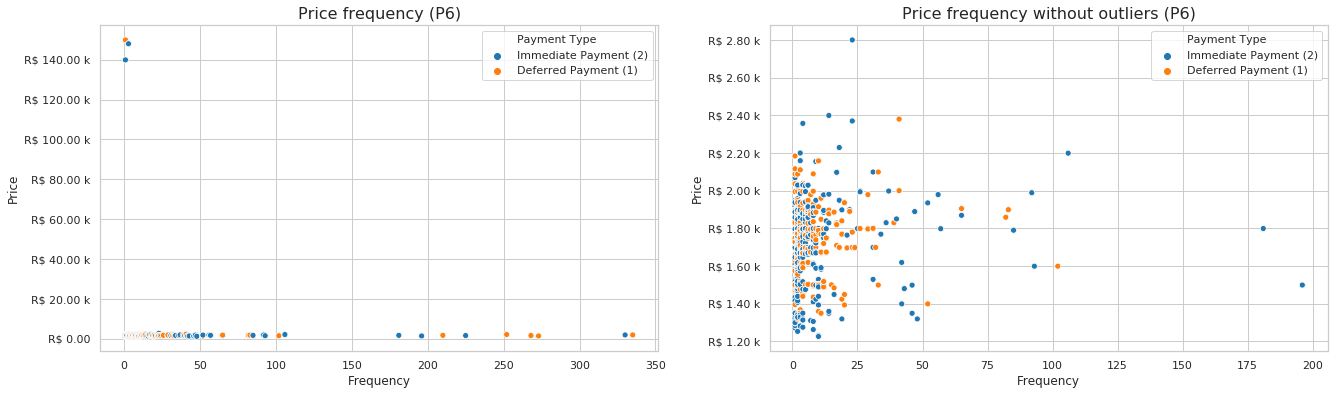

In [86]:
qt_price = df_comp[df_comp['PROD_ID'] == 'P6'].groupby(['COMPETITOR_PRICE', 'PAY_TYPE'])['PROD_ID'].count().sort_values().reset_index()
qt_price.columns = ['Price', 'Payment Type', 'Frequency']
qt_price['Payment Type'] = qt_price['Payment Type'].apply(set_payment_type)

print(qt_price.sort_values(ascending=False, by='Price')[:10])
print('')
print((qt_price.groupby('Payment Type').size() / qt_price.shape[0]) * 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

sns.scatterplot(
    x='Frequency', 
    y='Price',
    hue='Payment Type',
    palette='tab10',
    data=qt_price, 
    ax=ax1
)
ax1.set_title('Price frequency (P6)', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

sns.scatterplot(
    x='Frequency', 
    y='Price', 
    hue='Payment Type',
    palette='tab10',
    data=qt_price[(qt_price['Price'] < 40000) & (qt_price['Frequency'] < 200)], 
    ax=ax2
)
ax2.set_title('Price frequency without outliers (P6)', fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

plt.show()

- Podemos observar 6 valores distantes da média.
- Removendo-os podemos visualizar melhor os dados e ao plotarmos vemos um agrupamento forte entre 1 e 25 (frequência) e os seus preços entre 1250  à 2000.
- A distribuição de pagamentos encontram=se em 49% para pagamentos à vista e 51% para compras.

## P7

In [87]:
df_comp_p7 = df_comp[df_comp.PROD_ID == 'P7']
df_comp_p7.head(10)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY,COMP_PROD
9542,P7,2015-02-23 20:10:06,C4,849.00,1,2015-02-23,2015,2,23,0,C4.P7
9543,P7,2015-02-17 08:11:34,C6,849.00,2,2015-02-17,2015,2,17,1,C6.P7
9544,P7,2015-02-17 08:11:34,C4,721.65,2,2015-02-17,2015,2,17,1,C4.P7
9545,P7,2015-02-17 08:11:34,C1,899.05,2,2015-02-17,2015,2,17,1,C1.P7
9546,P7,2015-02-17 08:11:34,C3,1049.00,2,2015-02-17,2015,2,17,1,C3.P7
9547,P7,2015-02-17 08:10:23,C4,721.65,2,2015-02-17,2015,2,17,1,C4.P7
9548,P7,2015-02-17 08:10:23,C4,849.00,1,2015-02-17,2015,2,17,1,C4.P7
9549,P7,2015-02-12 08:11:35,C6,849.00,2,2015-02-12,2015,2,12,3,C6.P7
9550,P7,2015-02-12 08:11:35,C4,747.12,2,2015-02-12,2015,2,12,3,C4.P7
9551,P7,2015-02-12 08:11:35,C3,899.00,2,2015-02-12,2015,2,12,3,C3.P7


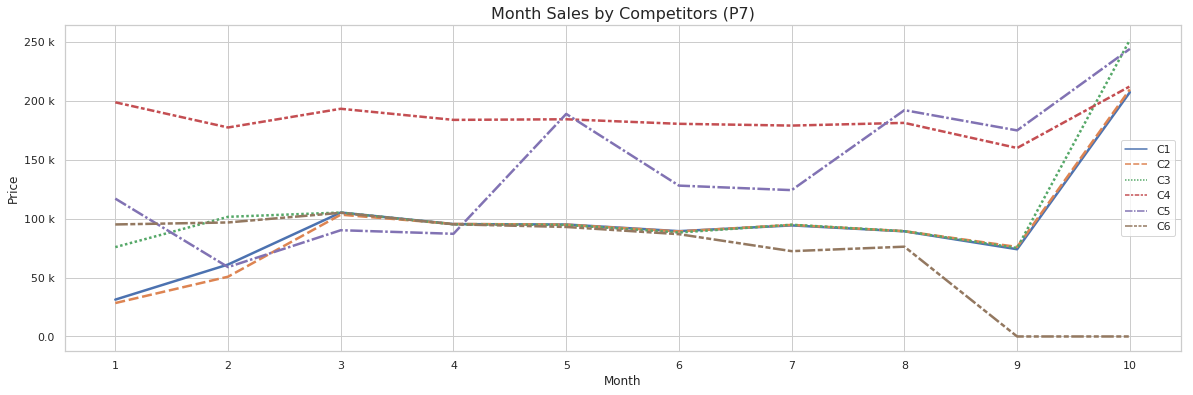

In [88]:
sales_by_comp_month = df_comp_p7.groupby(['MONTH', 'COMPETITOR'])['COMPETITOR_PRICE'].sum().reset_index()
sales_by_comp_month.columns = ['Month', 'Competitor', 'Price']

competitors = sales_by_comp_month.Competitor.sort_values().unique()
months = np.arange(10) + 1

total_competitors = sales_by_comp_month.Competitor.nunique()

values = []

for x in months:
    item = []
    
    for j in np.arange(total_competitors):
        price = sales_by_comp_month[(sales_by_comp_month['Month'] == x) & (sales_by_comp_month['Competitor'] == competitors[j])]['Price'].values
        
        item.append(round(price[0], 2) if len(price) > 0 else 0)

    values.append(item)

data = pd.DataFrame(
    data = values, 
    index = months,
    columns=competitors
)

f, ax1 = plt.subplots(1, 1, figsize=(20, 6))

sns.lineplot(data=data, linewidth=2.5, ax=ax1)
ax1.set_title('Month Sales by Competitors (P7)', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Price')

ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))

ax1.set_xticks(months)

plt.show()

- As vendas dos concorrentes possuem quase o mesmo comportamento, exceto o concorrente C5 e C6.
- o comportamento das vendas do concorrente C5 é crescente ao longo do tempo, porém existem diversas variações.
- Para o concorrente C6 é o inverso, as suas vendas vão decrescendo ao longo do tempo.

       Price           Payment Type  Frequency
4   104900.0   Deferred Payment (1)          1
46  104900.0  Immediate Payment (2)          1
24   86100.0   Deferred Payment (1)          1
26   84990.0   Deferred Payment (1)          1
25   84990.0  Immediate Payment (2)          1
27   84090.0  Immediate Payment (2)          1
28   84090.0   Deferred Payment (1)          1
29   77490.0  Immediate Payment (2)          1
31   69990.0   Deferred Payment (1)          1
30   69990.0  Immediate Payment (2)          1

Payment Type
Deferred Payment (1)     43.82716
Immediate Payment (2)    56.17284
dtype: float64


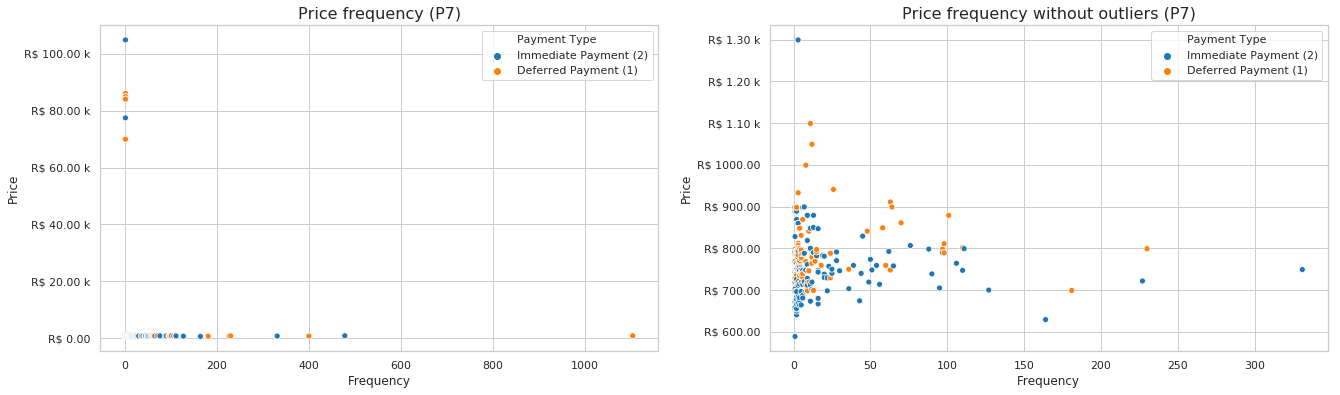

In [89]:
qt_price = df_comp[df_comp['PROD_ID'] == 'P7'].groupby(['COMPETITOR_PRICE', 'PAY_TYPE'])['PROD_ID'].count().sort_values().reset_index()
qt_price.columns = ['Price', 'Payment Type', 'Frequency']
qt_price['Payment Type'] = qt_price['Payment Type'].apply(set_payment_type)

print(qt_price.sort_values(ascending=False, by='Price')[:10])
print('')
print((qt_price.groupby('Payment Type').size() / qt_price.shape[0]) * 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

sns.scatterplot(
    x='Frequency', 
    y='Price',
    hue='Payment Type',
    palette='tab10',
    data=qt_price, 
    ax=ax1
)
ax1.set_title('Price frequency (P7)', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

sns.scatterplot(
    x='Frequency', 
    y='Price', 
    hue='Payment Type',
    palette='tab10',
    data=qt_price[(qt_price['Price'] < 40000) & (qt_price['Frequency'] < 400)], 
    ax=ax2
)
ax2.set_title('Price frequency without outliers (P7)', fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

plt.show()

- No primeiro gráfico podemos observar um grupo de valores distantes da média que encontram-se acima de 65 mil.
- Ao remove-los podemos visualizar um forte agrupamento entre a frequência de 1 à 100 e os valores de 580 à 910 mil.

## P8

In [90]:
df_comp_p8 = df_comp[df_comp.PROD_ID == 'P8']
df_comp_p8.head(10)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY,COMP_PROD
26698,P8,2015-06-18 08:11:39,C6,495.76,1,2015-06-18,2015,6,18,3,C6.P8
26699,P8,2015-06-18 08:11:39,C3,498.99,1,2015-06-18,2015,6,18,3,C3.P8
26700,P8,2015-06-18 08:11:39,C4,479.00,1,2015-06-18,2015,6,18,3,C4.P8
26701,P8,2015-06-18 08:11:39,C2,498.99,1,2015-06-18,2015,6,18,3,C2.P8
26702,P8,2015-06-18 08:11:39,C1,498.99,1,2015-06-18,2015,6,18,3,C1.P8
26703,P8,2015-06-16 20:10:25,C6,495.79,2,2015-06-16,2015,6,16,1,C6.P8
26704,P8,2015-06-16 20:10:25,C3,489.88,2,2015-06-16,2015,6,16,1,C3.P8
26705,P8,2015-06-16 20:10:25,C4,479.00,2,2015-06-16,2015,6,16,1,C4.P8
26706,P8,2015-06-16 20:10:25,C2,498.99,2,2015-06-16,2015,6,16,1,C2.P8
26707,P8,2015-06-16 20:10:25,C1,498.99,2,2015-06-16,2015,6,16,1,C1.P8


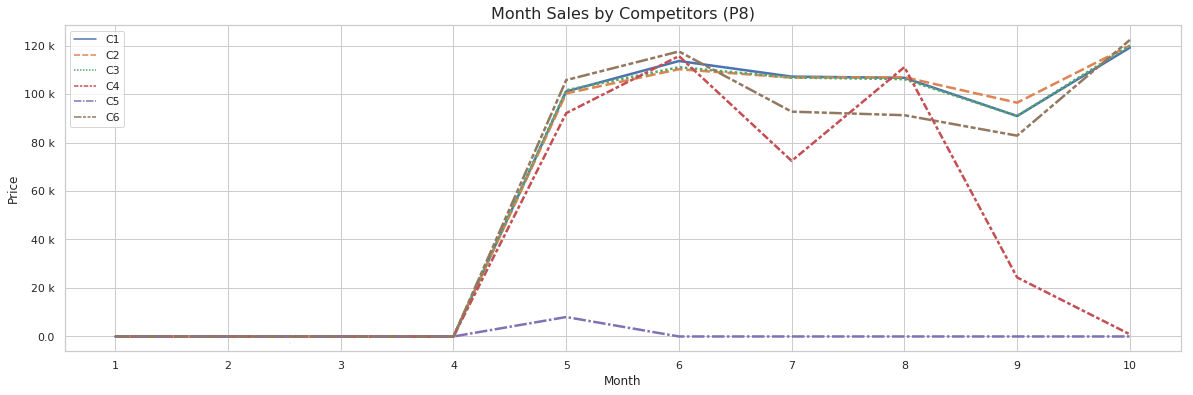

In [91]:
sales_by_comp_month = df_comp_p8.groupby(['MONTH', 'COMPETITOR'])['COMPETITOR_PRICE'].sum().reset_index()
sales_by_comp_month.columns = ['Month', 'Competitor', 'Price']

competitors = sales_by_comp_month.Competitor.sort_values().unique()
months = np.arange(10) + 1

total_competitors = sales_by_comp_month.Competitor.nunique()

values = []

for x in months:
    item = []
    
    for j in np.arange(total_competitors):
        price = sales_by_comp_month[(sales_by_comp_month['Month'] == x) & (sales_by_comp_month['Competitor'] == competitors[j])]['Price'].values
        
        item.append(round(price[0], 2) if len(price) > 0 else 0)

    values.append(item)

data = pd.DataFrame(
    data = values, 
    index = months,
    columns=competitors
)

f, ax1 = plt.subplots(1, 1, figsize=(20, 6))

sns.lineplot(data=data, linewidth=2.5, ax=ax1)
ax1.set_title('Month Sales by Competitors (P8)', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Price')

ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))

ax1.set_xticks(months)

plt.show()

- Todas as vendas para este produto começa a partir de abril, os concorrentes C1, C2, e C6 possuem comportamentos parecidos.
- O concorrente C4 tem uma grande venda em abril e no início de maio um aumento mais devagar, após este período podemos observar algumas varições e uma queda muito grande a partir do mês de agosto.

        Price           Payment Type  Frequency
169  39999.00  Immediate Payment (2)          1
17   39999.00   Deferred Payment (1)          1
352  39300.00  Immediate Payment (2)          3
349  39300.00   Deferred Payment (1)          3
299    636.00   Deferred Payment (1)          2
586    599.00  Immediate Payment (2)         16
612    599.00   Deferred Payment (1)         38
296    559.68  Immediate Payment (2)          2
587    539.10  Immediate Payment (2)         17
107    537.00  Immediate Payment (2)          1

Payment Type
Deferred Payment (1)     49.082569
Immediate Payment (2)    50.917431
dtype: float64


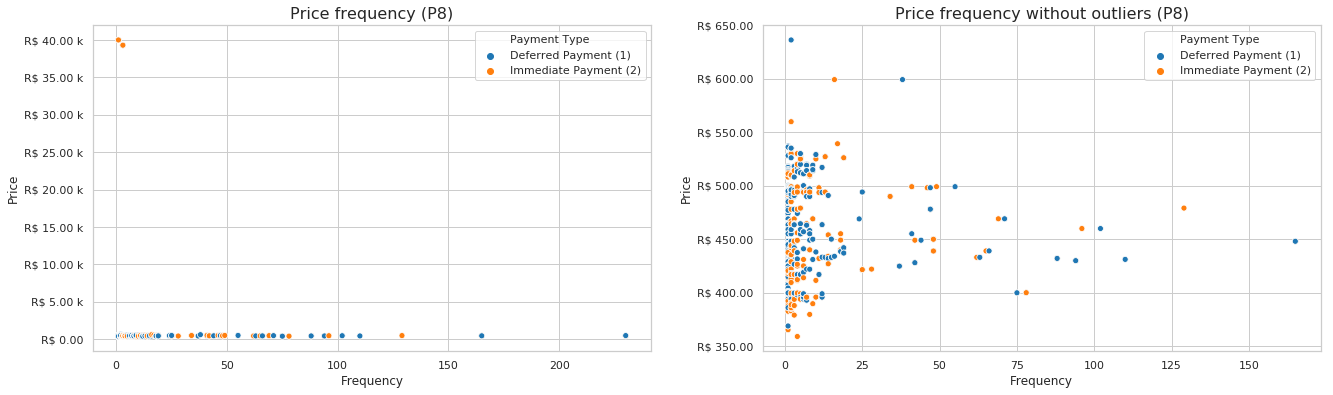

In [92]:
qt_price = df_comp[df_comp['PROD_ID'] == 'P8'].groupby(['COMPETITOR_PRICE', 'PAY_TYPE'])['PROD_ID'].count().sort_values().reset_index()
qt_price.columns = ['Price', 'Payment Type', 'Frequency']
qt_price['Payment Type'] = qt_price['Payment Type'].apply(set_payment_type)

print(qt_price.sort_values(ascending=False, by='Price')[:10])
print('')
print((qt_price.groupby('Payment Type').size() / qt_price.shape[0]) * 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

sns.scatterplot(
    x='Frequency', 
    y='Price',
    hue='Payment Type',
    palette='tab10',
    data=qt_price, 
    ax=ax1
)
ax1.set_title('Price frequency (P8)', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

sns.scatterplot(
    x='Frequency', 
    y='Price', 
    hue='Payment Type', 
    palette='tab10', 
    data=qt_price[(qt_price['Price'] < 30000) & (qt_price['Frequency'] < 200)], 
    ax=ax2
)
ax2.set_title('Price frequency without outliers (P8)', fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

plt.show()

- No primero gráfico podemos observar alguns outliers que tem os seus valores em torno de 39.300 e 40.000.
- Ao remove-los podemos observar um forte agrupamento nas frequências entre 1 e 25 e os seus valores entre 360 e 550.

## P9

In [93]:
df_comp_p9 = df_comp[df_comp.PROD_ID == 'P9']
df_comp_p9.head(10)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE,YEAR,MONTH,DAY,WEEKDAY,COMP_PROD
33508,P9,2015-06-18 08:11:39,C2,478.90,1,2015-06-18,2015,6,18,3,C2.P9
33509,P9,2015-06-18 08:11:39,C6,491.76,1,2015-06-18,2015,6,18,3,C6.P9
33510,P9,2015-06-18 08:11:39,C1,478.90,1,2015-06-18,2015,6,18,3,C1.P9
33511,P9,2015-06-18 08:11:39,C5,599.00,1,2015-06-18,2015,6,18,3,C5.P9
33512,P9,2015-06-18 08:11:39,C3,510.99,1,2015-06-18,2015,6,18,3,C3.P9
33513,P9,2015-06-16 20:10:08,C3,512.99,1,2015-06-16,2015,6,16,1,C3.P9
33514,P9,2015-06-16 20:10:08,C6,491.79,1,2015-06-16,2015,6,16,1,C6.P9
33515,P9,2015-06-16 20:10:08,C1,498.99,1,2015-06-16,2015,6,16,1,C1.P9
33516,P9,2015-06-16 20:10:08,C2,489.88,1,2015-06-16,2015,6,16,1,C2.P9
33517,P9,2015-06-16 20:10:25,C1,512.99,2,2015-06-16,2015,6,16,1,C1.P9


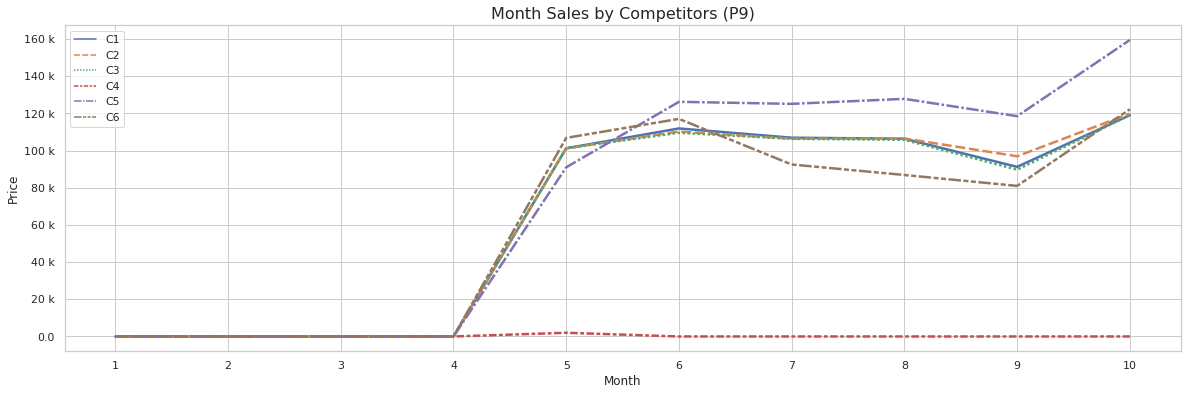

In [94]:
sales_by_comp_month = df_comp_p9.groupby(['MONTH', 'COMPETITOR'])['COMPETITOR_PRICE'].sum().reset_index()
sales_by_comp_month.columns = ['Month', 'Competitor', 'Price']

competitors = sales_by_comp_month.Competitor.sort_values().unique()
months = np.arange(10) + 1

total_competitors = sales_by_comp_month.Competitor.nunique()

values = []

for x in months:
    item = []
    
    for j in np.arange(total_competitors):
        price = sales_by_comp_month[(sales_by_comp_month['Month'] == x) & (sales_by_comp_month['Competitor'] == competitors[j])]['Price'].values
        
        item.append(round(price[0], 2) if len(price) > 0 else 0)

    values.append(item)

data = pd.DataFrame(
    data = values, 
    index = months,
    columns=competitors
)

f, ax1 = plt.subplots(1, 1, figsize=(20, 6))

sns.lineplot(data=data, linewidth=2.5, ax=ax1)
ax1.set_title('Month Sales by Competitors (P9)', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Price')

ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_frequency))

ax1.set_xticks(months)

plt.show()

- O comportamento do produto P9 é bem parecido com o produto P8, porém o que muda são os comportamentos dos concorrentes.
- No gráfico podemos visualizar que o concorrente C4 não possui praticamente nenhuma venda para este produto, enquanto outros um alto crescimento nas vendas a partir do mês de abril e tendo poucas varições ao longo do tempo.

        Price           Payment Type  Frequency
0    56900.00   Deferred Payment (1)          1
153  50072.00  Immediate Payment (2)          1
120  39999.00   Deferred Payment (1)          1
162  39999.00  Immediate Payment (2)          1
304  39300.00   Deferred Payment (1)          3
301  39300.00  Immediate Payment (2)          3
246    636.00   Deferred Payment (1)          2
617    599.00   Deferred Payment (1)        293
560    579.00   Deferred Payment (1)         25
535    569.05  Immediate Payment (2)         16

Payment Type
Deferred Payment (1)     48.867314
Immediate Payment (2)    51.132686
dtype: float64


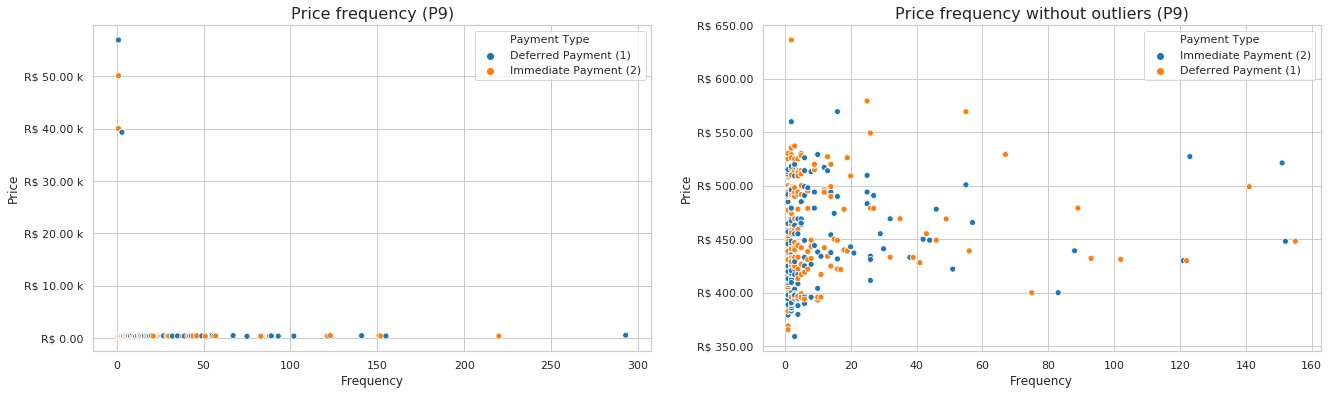

In [95]:
qt_price = df_comp[df_comp['PROD_ID'] == 'P9'].groupby(['COMPETITOR_PRICE', 'PAY_TYPE'])['PROD_ID'].count().sort_values().reset_index()
qt_price.columns = ['Price', 'Payment Type', 'Frequency']
qt_price['Payment Type'] = qt_price['Payment Type'].apply(set_payment_type)

print(qt_price.sort_values(ascending=False, by='Price')[:10])
print('')
print((qt_price.groupby('Payment Type').size() / qt_price.shape[0]) * 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))

sns.scatterplot(
    x='Frequency', 
    y='Price', 
    hue='Payment Type', 
    palette='tab10', 
    data=qt_price, 
    ax=ax1
)
ax1.set_title('Price frequency (P9)', fontsize=16)
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

sns.scatterplot(
    x='Frequency', 
    y='Price', 
    hue='Payment Type', 
    palette='tab10', 
    data=qt_price[(qt_price['Price'] < 30000) & (qt_price['Frequency'] < 200)], 
    ax=ax2
)
ax2.set_title('Price frequency without outliers (P9)', fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(y_fmt_value))

plt.show()

- Conforme apresentado no primeiro gráfico, podemos observar alguns outliers que estão variando entre 39.300 à 56.900.
- No segundo gráfico podemos visualizar um agrupamento forte da frequência entre 1 e 20 e os seus valores entre 360 à 540.